In [1]:
import pandas as pd
import numpy as np

# Use the yfinance library to download historical stock data for NVIDIA (NVDA)
# From January 1, 2015, to the present day.
#!pip install yfinance
import yfinance as yf
nvda = yf.download('NVDA', start='2015-01-01')  
print(nvda.tail())

# Check for missing values in the dataset
print(nvda.isna().sum().sum())
# As there are no missing values, we can proceed with the analysis.

# Import the technical analysis library
#!pip install ta 
import ta

# Add Returns to dataset as this will be used as a target variable
nvda['Return'] = nvda['Close'].pct_change().shift(-1)
# Drop the first row as it will have NaN value for Returns
nvda = nvda.dropna()

print(nvda.tail())

/var/folders/py/pk80p4l95gjbynd00fzl_3d00000gn/T/ipykernel_35299/811224584.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nvda = yf.download('NVDA', start='2015-01-01')
[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open     Volume
Ticker            NVDA        NVDA        NVDA        NVDA       NVDA
Date                                                                 
2025-08-25  179.809998  181.910004  176.570007  178.350006  163012800
2025-08-26  181.770004  182.389999  178.809998  180.059998  168688200
2025-08-27  181.600006  182.490005  179.100006  181.979996  235518900
2025-08-28  180.169998  184.470001  176.410004  180.820007  281787800
2025-08-29  174.179993  178.149994  173.149994  178.110001  242726800
0
Price            Close        High         Low        Open     Volume  \
Ticker            NVDA        NVDA        NVDA        NVDA       NVDA   
Date                                                                    
2025-08-22  177.990005  178.589996  171.199997  172.610001  172789400   
2025-08-25  179.809998  181.910004  176.570007  178.350006  163012800   
2025-08-26  181.770004  182.389999  178.809998  180.059998  168688200   


I will start by adding lots of potentially relevant features to the data and then pruning to find the best combination of features for the model

In [2]:
# Feature Engineering
# Adding basic features

# Rolling Statistics
nvda['MA5'] = nvda['Close'].rolling(window=5).mean()
nvda['MA10'] = nvda['Close'].rolling(window=10).mean()
nvda['MA20'] = nvda['Close'].rolling(window=20).mean()

# Volatility
nvda['Volatility5'] = nvda['Return'].rolling(window=5).std()
nvda['Volatility10'] = nvda['Return'].rolling(window=10).std()

# Momentum
nvda['Momentum5'] = nvda['Close'] - nvda['Close'].shift(5)
nvda['Momentum10'] = nvda['Close'] - nvda['Close'].shift(10)

# Price Ratios
nvda['Close_Open'] = nvda['Close'] / nvda['Open']
nvda['High_Low'] = nvda['High'] / nvda['Low']

# Volume Change
nvda['Volume_Change'] = nvda['Volume'].pct_change()

# Drop rows with NaNs caused by rolling calculations
nvda.dropna(inplace=True)

# Check the final dataset with features
print(nvda.tail())

# Displaying the columns to verify the features added
print(nvda.columns.tolist())





Price            Close        High         Low        Open     Volume  \
Ticker            NVDA        NVDA        NVDA        NVDA       NVDA   
Date                                                                    
2025-08-22  177.990005  178.589996  171.199997  172.610001  172789400   
2025-08-25  179.809998  181.910004  176.570007  178.350006  163012800   
2025-08-26  181.770004  182.389999  178.809998  180.059998  168688200   
2025-08-27  181.600006  182.490005  179.100006  181.979996  235518900   
2025-08-28  180.169998  184.470001  176.410004  180.820007  281787800   

Price         Return         MA5        MA10        MA20 Volatility5  \
Ticker                                                                 
Date                                                                   
2025-08-22  0.010225  177.203998  179.529999  178.978499    0.020045   
2025-08-25  0.010900  176.763998  179.304999  179.131499    0.008484   
2025-08-26 -0.000935  177.989999  179.165999  179.44449

Making a function to automate carrying out/ evaluating the model.

In [3]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import numpy as np

def train_lgb_model(X, y, n_splits=5, params=None, num_boost_round=1000, early_stopping_rounds=50):
    """
    Trains and evaluates a LightGBM model using TimeSeriesSplit for regression.
    
    Args:
        X (pd.DataFrame): Features.
        y (pd.Series): Target.
        n_splits (int): Number of time series splits.
        params (dict): LightGBM parameters.
        num_boost_round (int): Maximum number of boosting iterations.
        early_stopping_rounds (int): Early stopping rounds.
    
    Returns:
        list: List of validation RMSE scores for each fold.
    """
    if params is None:
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'verbosity': -1
        }
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rmse_scores = []
    train_rmse_scores = []
    val_std_devs = []  # Store validation target standard deviations
    up_down_accuracies = []  # Store up/down accuracies
    sharpe_ratios = []  # Store Sharpe ratios
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X), 1):  # start fold count at 1
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val)
        
        model = lgb.train(
            params,
            train_data,
            num_boost_round=num_boost_round,
            valid_sets=[val_data],
            callbacks=[lgb.early_stopping(stopping_rounds=early_stopping_rounds)]
        )
        
        # Predictions
        val_preds = model.predict(X_val)
        train_preds = model.predict(X_train)
        
        # RMSE calculations
        val_rmse = mean_squared_error(y_val, val_preds, squared=False)
        train_rmse = mean_squared_error(y_train, train_preds, squared=False)
        
        # Standard deviation of validation targets
        val_std = np.std(y_val)
        val_std_devs.append(val_std)
        
        # Up/down accuracy (percentage of times predicted and actual returns had same sign)
        same_sign = np.sign(val_preds) == np.sign(y_val)
        up_down_acc = np.mean(same_sign) * 100  # Convert to percentage
        up_down_accuracies.append(up_down_acc)
        
        # Sharpe ratio (no threshold)
        positions = np.sign(val_preds)
        strategy_returns = positions * y_val
        if strategy_returns.std() > 0:
            sharpe = np.sqrt(252) * (strategy_returns.mean() / strategy_returns.std())
        else:
            sharpe = 0
        sharpe_ratios.append(sharpe)
        
        # Collect scores
        rmse_scores.append(val_rmse)
        train_rmse_scores.append(train_rmse)
        
        print(f"Fold {fold} - Train RMSE: {train_rmse:.4f} | Validation RMSE: {val_rmse:.4f}")
        print(f"           Validation Std Dev: {val_std:.4f} | Up/Down Accuracy: {up_down_acc:.2f}% | Sharpe: {sharpe:.3f}")
    
    # Plot validation RMSE vs fold
    # Add a second subplot for Sharpe ratios
    plt.figure(figsize=(15, 5))

    # First subplot - existing RMSE plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, n_splits + 1), rmse_scores, marker='o', linestyle='-', label='Validation RMSE')
    plt.plot(range(1, n_splits + 1), train_rmse_scores, marker='x', linestyle='--', label='Train RMSE')
    plt.xlabel('Fold')
    plt.ylabel('RMSE')
    plt.title('Train vs Validation RMSE per Fold')
    plt.legend()
    plt.grid(True)

    # Second subplot - new Sharpe plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, n_splits + 1), sharpe_ratios, marker='s', linestyle='-', color='green', linewidth=2, markersize=8)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Zero (no edge)')
    plt.axhline(y=1, color='gold', linestyle='--', alpha=0.5, label='1.0 (good threshold)')
    plt.xlabel('Fold')
    plt.ylabel('Sharpe Ratio')
    plt.title('Sharpe Ratio per Fold')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print(f"Average RMSE Gap (Validation - Train): {np.mean(np.array(rmse_scores) - np.array(train_rmse_scores)):.4f}")
    
    # Print overall metrics
    print(f"\n--- Overall Metrics ---")
    print(f"Return volatility: {np.mean(val_std_devs):.4f}")
    print(f"Average up/down accuracy across all folds: {np.mean(up_down_accuracies):.2f}%")
    print(f"Average Sharpe ratio across all folds: {np.mean(sharpe_ratios):.3f}")
    print(f"Average validation RMSE across all folds: {np.mean(rmse_scores):.4f}")
    print(f"Validation RMSE < Validation Std Dev: {sum(rmse < std for rmse, std in zip(rmse_scores, val_std_devs))}/{n_splits} folds")
    
    return rmse_scores, model


['Close', 'High', 'Low', 'Open', 'Volume', 'Return', 'MA5', 'MA10', 'MA20', 'Volatility5', 'Volatility10', 'Momentum5', 'Momentum10', 'Close_Open', 'High_Low', 'Volume_Change']
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's rmse: 0.0287835
Fold 1 - Train RMSE: 0.0209 | Validation RMSE: 0.0288
           Validation Std Dev: 0.0289 | Up/Down Accuracy: 55.53% | Sharpe: 1.722
Training until validation scores don't improve for 50 rounds


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

Early stopping, best iteration is:
[1]	valid_0's rmse: 0.035209
Fold 2 - Train RMSE: 0.0250 | Validation RMSE: 0.0352
           Validation Std Dev: 0.0351 | Up/Down Accuracy: 53.05% | Sharpe: 0.583
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0284575
Fold 3 - Train RMSE: 0.0285 | Validation RMSE: 0.0285
           Validation Std Dev: 0.0285 | Up/Down Accuracy: 54.63% | Sharpe: 1.508
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0361121


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 4 - Train RMSE: 0.0286 | Validation RMSE: 0.0361
           Validation Std Dev: 0.0361 | Up/Down Accuracy: 50.79% | Sharpe: 0.800
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	valid_0's rmse: 0.0327514
Fold 5 - Train RMSE: 0.0285 | Validation RMSE: 0.0328
           Validation Std Dev: 0.0331 | Up/Down Accuracy: 51.69% | Sharpe: 1.540


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


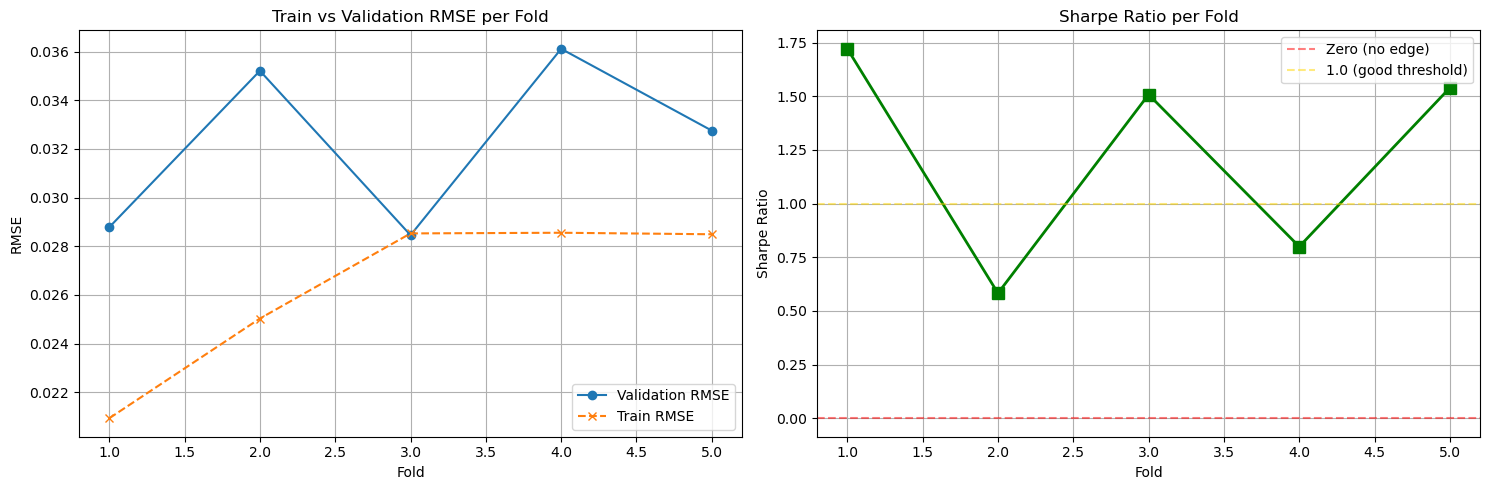

Average RMSE Gap (Validation - Train): 0.0060

--- Overall Metrics ---
Return volatility: 0.0323
Average up/down accuracy across all folds: 53.14%
Average Sharpe ratio across all folds: 1.230
Average validation RMSE across all folds: 0.0323
Validation RMSE < Validation Std Dev: 4/5 folds
([0.028783474241573175, 0.03520900175866523, 0.028457510893791216, 0.0361120967311266, 0.03275139968963728], <lightgbm.basic.Booster object at 0x1336cc830>)


In [4]:
# Flatten MultiIndex columns to single string names
nvda.columns = [col[0] if isinstance(col, tuple) else col for col in nvda.columns]
print(nvda.columns.tolist())

# Testing model on original features
X = nvda.drop(columns=['Return', 'Close', 'High', 'Low', 'Open'])
y = nvda['Return']

print(train_lgb_model(X, y))

Adding more technical features

['Close', 'High', 'Low', 'Open', 'Volume', 'Return', 'MA5', 'MA10', 'MA20', 'Volatility5', 'Volatility10', 'Momentum5', 'Momentum10', 'Close_Open', 'High_Low', 'Volume_Change', 'Return_1', 'Return_2', 'Return_3', 'Daily_Range', 'Max10', 'Min10', 'Close_to_High10', 'Close_to_Low10', 'Dev_MA5', 'Dev_MA10', 'AvgVol5', 'Vol/AvgVol5', 'RSI', 'MACD', 'Signal_Line', 'Body', 'Upper_Wick', 'Lower_Wick', 'Body/Range', 'VPT', 'BB_upper', 'BB_lower', 'BB_width', 'Stoch_%K', 'Stoch_%D', 'ATR', 'Momentum_3', 'Momentum_7', 'Momentum_14', 'AvgVol10', 'AvgVol20', 'Vol_Oscillator']
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	valid_0's rmse: 0.028793
Fold 1 - Train RMSE: 0.0203 | Validation RMSE: 0.0288
           Validation Std Dev: 0.0289 | Up/Down Accuracy: 55.30% | Sharpe: 1.875
Training until validation scores don't improve for 50 rounds


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0352531
Fold 2 - Train RMSE: 0.0249 | Validation RMSE: 0.0353
           Validation Std Dev: 0.0351 | Up/Down Accuracy: 53.05% | Sharpe: 0.583
Training until validation scores don't improve for 50 rounds


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0286377
Fold 3 - Train RMSE: 0.0283 | Validation RMSE: 0.0286
           Validation Std Dev: 0.0285 | Up/Down Accuracy: 55.30% | Sharpe: 0.916
Training until validation scores don't improve for 50 rounds


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0360953
Fold 4 - Train RMSE: 0.0284 | Validation RMSE: 0.0361
           Validation Std Dev: 0.0361 | Up/Down Accuracy: 52.82% | Sharpe: 1.286
Training until validation scores don't improve for 50 rounds


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Early stopping, best iteration is:
[4]	valid_0's rmse: 0.0329671
Fold 5 - Train RMSE: 0.0284 | Validation RMSE: 0.0330
           Validation Std Dev: 0.0331 | Up/Down Accuracy: 51.92% | Sharpe: 0.651


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


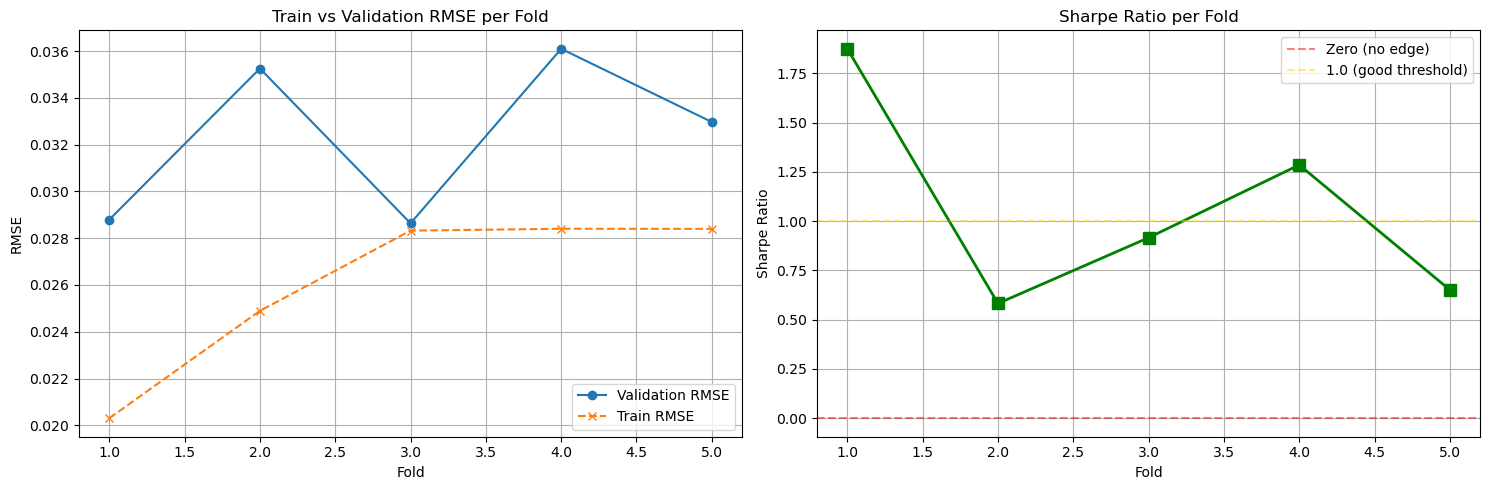

Average RMSE Gap (Validation - Train): 0.0063

--- Overall Metrics ---
Return volatility: 0.0323
Average up/down accuracy across all folds: 53.68%
Average Sharpe ratio across all folds: 1.062
Average validation RMSE across all folds: 0.0323
Validation RMSE < Validation Std Dev: 3/5 folds
([0.028793027243122132, 0.035253133683771434, 0.028637705214321425, 0.036095314934974386, 0.03296706629218236], <lightgbm.basic.Booster object at 0x1337fee40>)


In [5]:
close = nvda['Close']
high = nvda['High']
low = nvda['Low']
open_ = nvda['Open']
volume = nvda['Volume']


# Lagged Returns - recent return history to capture momentum
nvda['Return_1'] = nvda['Return'].shift(1)
nvda['Return_2'] = nvda['Return'].shift(2)
nvda['Return_3'] = nvda['Return'].shift(3)

# Daily Range - intraday volatility measure
nvda['Daily_Range'] = high - low

# Rolling Max/Min - price extremes over past 10 days
nvda['Max10'] = close.rolling(window=10).max()
nvda['Min10'] = close.rolling(window=10).min()
nvda['Close_to_High10'] = close / nvda['Max10']
nvda['Close_to_Low10'] = close / nvda['Min10']

# Price Deviation from Moving Averages - mean reversion signals
nvda['Dev_MA5'] = close - nvda['MA5']
nvda['Dev_MA10'] = close - nvda['MA10']

# Rolling Average Volume and Volume Spike ratio
nvda['AvgVol5'] = volume.rolling(window=5).mean()
nvda['Vol/AvgVol5'] = volume / nvda['AvgVol5']  # large values could indicate unusual activity

# RSI (Relative Strength Index) - momentum and reversal indicator
delta = close.diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
nvda['RSI'] = 100 - (100 / (1 + rs))

# MACD and Signal Line - trend following and momentum
ema12 = close.ewm(span=12, adjust=False).mean()
ema26 = close.ewm(span=26, adjust=False).mean()
nvda['MACD'] = ema12 - ema26
nvda['Signal_Line'] = nvda['MACD'].ewm(span=9, adjust=False).mean()

# Candle Body and Wick Ratios - indicate market sentiment within day
nvda['Body'] = abs(close - open_)
nvda['Upper_Wick'] = high - np.maximum(close, open_)
nvda['Lower_Wick'] = np.minimum(close, open_) - low
nvda['Body/Range'] = nvda['Body'] / nvda['Daily_Range']

# Volume Price Trend (VPT) - cumulative volume weighted price change, volume + price action
nvda['VPT'] = (volume * close.pct_change()).cumsum()

# Bollinger Bands - volatility bands around MA20
nvda['MA20'] = close.rolling(window=20).mean()  # just in case not added yet
nvda['BB_upper'] = nvda['MA20'] + 2 * close.rolling(window=20).std()
nvda['BB_lower'] = nvda['MA20'] - 2 * close.rolling(window=20).std()
nvda['BB_width'] = nvda['BB_upper'] - nvda['BB_lower']  # width as volatility measure

# Stochastic Oscillator (%K and %D) - momentum oscillator
lowest_low_14 = low.rolling(window=14).min()
highest_high_14 = high.rolling(window=14).max()
nvda['Stoch_%K'] = 100 * (close - lowest_low_14) / (highest_high_14 - lowest_low_14)
nvda['Stoch_%D'] = nvda['Stoch_%K'].rolling(window=3).mean()

# ATR (Average True Range) - volatility measure based on high-low and gaps
high_low = high - low
high_close_prev = abs(high - close.shift(1))
low_close_prev = abs(low - close.shift(1))
true_range = pd.Series(np.maximum.reduce([high_low, high_close_prev, low_close_prev]), index=nvda.index)
nvda['ATR'] = true_range.rolling(window=14).mean()

# Momentum Indicators - price change over different lags (some you have but adding more)
nvda['Momentum_3'] = close - close.shift(3)
nvda['Momentum_7'] = close - close.shift(7)
nvda['Momentum_14'] = close - close.shift(14)

# Volume Moving Averages - different windows to capture volume trends
nvda['AvgVol10'] = volume.rolling(window=10).mean()
nvda['AvgVol20'] = volume.rolling(window=20).mean()

# Volume Oscillator - difference between short and long volume MAs
nvda['Vol_Oscillator'] = nvda['AvgVol5'] - nvda['AvgVol20']

print(nvda.columns.tolist())

# Testing model with extra features
X_1 = nvda.drop(columns=['Return', 'Close', 'High', 'Low', 'Open'])
y_1 = nvda['Return']

print(train_lgb_model(X_1, y_1))


Those features improved performance a lot, let's add even more!

In [6]:
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

def add_technical_indicators(df):
    """
    Add all possible technical indicators to the NVDA dataset
    df should have columns: Open, High, Low, Close, Volume
    """
    
    # Make a copy to avoid modifying original
    df = df.copy()
    
    # Ensure we have the basic price columns
    high = df['High']
    low = df['Low']
    close = df['Close']
    open_price = df['Open']
    volume = df['Volume']
    
    # Calculate returns if not already present
    if 'Return' not in df.columns:
        df['Return'] = close.pct_change()
    
    # 1. Moving Averages
    df['EMA12'] = close.ewm(span=12, adjust=False).mean()
    df['EMA26'] = close.ewm(span=26, adjust=False).mean()
    df['EMA50'] = close.ewm(span=50, adjust=False).mean()
    df['EMA200'] = close.ewm(span=200, adjust=False).mean()
    
    # DEMA (Double Exponential Moving Average)
    ema12 = df['EMA12']
    df['DEMA'] = 2 * ema12 - ema12.ewm(span=12, adjust=False).mean()
    
    # TEMA (Triple Exponential Moving Average)
    ema1 = close.ewm(span=12, adjust=False).mean()
    ema2 = ema1.ewm(span=12, adjust=False).mean()
    ema3 = ema2.ewm(span=12, adjust=False).mean()
    df['TEMA'] = 3 * ema1 - 3 * ema2 + ema3
    
    # WMA (Weighted Moving Average)
    def wma(data, period):
        weights = np.arange(1, period + 1)
        return data.rolling(period).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True)
    
    df['WMA10'] = wma(close, 10)
    df['WMA20'] = wma(close, 20)
    
    # HMA (Hull Moving Average)
    wma_half = wma(close, 10//2)
    wma_full = wma(close, 10)
    df['HMA'] = wma(2 * wma_half - wma_full, int(np.sqrt(10)))
    
    # KAMA (Kaufman Adaptive Moving Average)
    def kama(close, period=10, fast=2, slow=30):
        change = (close - close.shift(period)).abs()
        volatility = (close - close.shift(1)).abs().rolling(period).sum()
        efficiency_ratio = change / volatility
        smooth = ((efficiency_ratio * (2/(fast+1) - 2/(slow+1)) + 2/(slow+1)) ** 2)
        kama = np.zeros_like(close)
        kama[period] = close.iloc[period]
        for i in range(period + 1, len(close)):
            kama[i] = kama[i-1] + smooth.iloc[i] * (close.iloc[i] - kama[i-1])
        return pd.Series(kama, index=close.index)
    
    df['KAMA'] = kama(close)
    
    # T3 (Tillson T3)
    def t3(data, period=5, volume_factor=0.7):
        ema1 = data.ewm(span=period, adjust=False).mean()
        ema2 = ema1.ewm(span=period, adjust=False).mean()
        ema3 = ema2.ewm(span=period, adjust=False).mean()
        ema4 = ema3.ewm(span=period, adjust=False).mean()
        ema5 = ema4.ewm(span=period, adjust=False).mean()
        ema6 = ema5.ewm(span=period, adjust=False).mean()
        
        c1 = -volume_factor**3
        c2 = 3*volume_factor**2 + 3*volume_factor**3
        c3 = -6*volume_factor**2 - 3*volume_factor - 3*volume_factor**3
        c4 = 1 + 3*volume_factor + volume_factor**3 + 3*volume_factor**2
        
        return c1*ema6 + c2*ema5 + c3*ema4 + c4*ema3
    
    df['T3'] = t3(close)
    
    # 2. Momentum Indicators
    
    # Williams %R
    df['Williams_%R'] = ((high.rolling(14).max() - close) / 
                         (high.rolling(14).max() - low.rolling(14).min())) * -100
    
    # CCI (Commodity Channel Index)
    typical_price = (high + low + close) / 3
    sma_tp = typical_price.rolling(20).mean()
    mad = typical_price.rolling(20).apply(lambda x: np.abs(x - x.mean()).mean())
    df['CCI'] = (typical_price - sma_tp) / (0.015 * mad)
    
    # CMO (Chande Momentum Oscillator)
    close_diff = close.diff()
    up_sum = close_diff.where(close_diff > 0, 0).rolling(14).sum()
    down_sum = (-close_diff.where(close_diff < 0, 0)).rolling(14).sum()
    df['CMO'] = 100 * (up_sum - down_sum) / (up_sum + down_sum)
    
    # ROC (Rate of Change)
    df['ROC'] = ((close - close.shift(10)) / close.shift(10)) * 100
    
    # TRIX
    ema1 = close.ewm(span=14, adjust=False).mean()
    ema2 = ema1.ewm(span=14, adjust=False).mean()
    ema3 = ema2.ewm(span=14, adjust=False).mean()
    df['TRIX'] = (ema3 - ema3.shift(1)) / ema3.shift(1) * 100
    df['TRIX_Signal'] = df['TRIX'].rolling(9).mean()
    
    # Ultimate Oscillator
    bp = close - np.minimum(low, close.shift(1))
    tr = np.maximum(high, close.shift(1)) - np.minimum(low, close.shift(1))
    avg7 = bp.rolling(7).sum() / tr.rolling(7).sum()
    avg14 = bp.rolling(14).sum() / tr.rolling(14).sum()
    avg28 = bp.rolling(28).sum() / tr.rolling(28).sum()
    df['Ultimate_Oscillator'] = 100 * ((4 * avg7) + (2 * avg14) + avg28) / 7
    
    # Stochastic RSI
    if 'RSI' in df.columns:
        rsi = df['RSI']
    else:
        delta = close.diff()
        gain = delta.where(delta > 0, 0).rolling(14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
    
    rsi_min = rsi.rolling(14).min()
    rsi_max = rsi.rolling(14).max()
    df['Stoch_RSI'] = (rsi - rsi_min) / (rsi_max - rsi_min)
    
    # 3. Volume Indicators
    
    # MFI (Money Flow Index)
    typical_price = (high + low + close) / 3
    money_flow = typical_price * volume
    
    positive_flow = money_flow.where(typical_price > typical_price.shift(1), 0).rolling(14).sum()
    negative_flow = money_flow.where(typical_price < typical_price.shift(1), 0).rolling(14).sum()
    
    money_ratio = positive_flow / negative_flow
    df['MFI'] = 100 - (100 / (1 + money_ratio))
    df['Money_Flow_Index'] = df['MFI']  # Duplicate name in the list
    
    # A/D Line (Accumulation/Distribution)
    clv = ((close - low) - (high - close)) / (high - low)
    clv = clv.fillna(0)
    df['A/D_Line'] = (clv * volume).cumsum()
    
    # OBV (On-Balance Volume)
    obv = np.where(close > close.shift(1), volume,
                   np.where(close < close.shift(1), -volume, 0))
    df['OBV'] = pd.Series(obv, index=df.index).cumsum()
    
    # Chaikin Oscillator
    adl = df['A/D_Line']
    df['Chaikin_Oscillator'] = adl.ewm(span=3, adjust=False).mean() - adl.ewm(span=10, adjust=False).mean()
    
    # VWAP (Volume Weighted Average Price)
    df['VWAP'] = (typical_price * volume).cumsum() / volume.cumsum()
    
    # Price Volume Trend
    df['Price_Volume_Trend'] = ((close - close.shift(1)) / close.shift(1) * volume).cumsum()
    
    # Ease of Movement
    distance_moved = (high + low) / 2 - (high.shift(1) + low.shift(1)) / 2
    emv = distance_moved / (volume / 1e6) / (high - low)
    df['Ease_of_Movement'] = emv.rolling(14).mean()
    
    # Force Index
    df['Force_Index'] = close.diff() * volume
    
    # NVI (Negative Volume Index)
    nvi = pd.Series(index=df.index, dtype=float)
    nvi.iloc[0] = 1000
    for i in range(1, len(df)):
        if volume.iloc[i] < volume.iloc[i-1]:
            nvi.iloc[i] = nvi.iloc[i-1] * (1 + df['Return'].iloc[i])
        else:
            nvi.iloc[i] = nvi.iloc[i-1]
    df['NVI'] = nvi
    df['Negative_Volume_Index'] = nvi  # Duplicate
    
    # PVI (Positive Volume Index)
    pvi = pd.Series(index=df.index, dtype=float)
    pvi.iloc[0] = 1000
    for i in range(1, len(df)):
        if volume.iloc[i] > volume.iloc[i-1]:
            pvi.iloc[i] = pvi.iloc[i-1] * (1 + df['Return'].iloc[i])
        else:
            pvi.iloc[i] = pvi.iloc[i-1]
    df['PVI'] = pvi
    df['Positive_Volume_Index'] = pvi  # Duplicate
    
    # Chaikin Money Flow
    clv = ((close - low) - (high - close)) / (high - low)
    clv = clv.fillna(0)
    df['Chaikin_Money_Flow'] = (clv * volume).rolling(20).sum() / volume.rolling(20).sum()
    
    # Volume Weighted RSI
    volume_weighted_delta = close.diff() * volume
    gain = volume_weighted_delta.where(volume_weighted_delta > 0, 0).rolling(14).sum()
    loss = (-volume_weighted_delta.where(volume_weighted_delta < 0, 0)).rolling(14).sum()
    rs = gain / loss
    df['Volume_Weighted_RSI'] = 100 - (100 / (1 + rs))
    
    # 4. Trend Indicators
    
    # Aroon
    high_period = 25
    low_period = 25
    df['Aroon_Up'] = high.rolling(high_period + 1).apply(
        lambda x: (high_period - (high_period - np.argmax(x))) / high_period * 100)
    df['Aroon_Down'] = low.rolling(low_period + 1).apply(
        lambda x: (low_period - (low_period - np.argmin(x))) / low_period * 100)
    df['Aroon_Oscillator'] = df['Aroon_Up'] - df['Aroon_Down']
    
    # ADX (Average Directional Index)
    tr = np.maximum(high - low, 
                    np.maximum(abs(high - close.shift(1)), 
                              abs(low - close.shift(1))))
    
    up_move = high - high.shift(1)
    down_move = low.shift(1) - low
    
    plus_dm = np.where((up_move > down_move) & (up_move > 0), up_move, 0)
    minus_dm = np.where((down_move > up_move) & (down_move > 0), down_move, 0)
    
    tr_smooth = tr.rolling(14).sum()
    plus_di = 100 * pd.Series(plus_dm).rolling(14).sum() / tr_smooth
    minus_di = 100 * pd.Series(minus_dm).rolling(14).sum() / tr_smooth
    
    dx = 100 * abs(plus_di - minus_di) / (plus_di + minus_di)
    df['ADX'] = dx.rolling(14).mean()
    df['DI+'] = plus_di
    df['DI-'] = minus_di
    
    # Parabolic SAR
    def parabolic_sar(high, low, close, af=0.02, max_af=0.2):
        psar = close.copy()
        bull = True
        af_current = af
        ep = high.iloc[0] if bull else low.iloc[0]
        
        for i in range(1, len(close)):
            if bull:
                psar.iloc[i] = psar.iloc[i-1] + af_current * (ep - psar.iloc[i-1])
                if low.iloc[i] < psar.iloc[i]:
                    bull = False
                    psar.iloc[i] = ep
                    ep = low.iloc[i]
                    af_current = af
                else:
                    if high.iloc[i] > ep:
                        ep = high.iloc[i]
                        af_current = min(af_current + af, max_af)
            else:
                psar.iloc[i] = psar.iloc[i-1] + af_current * (ep - psar.iloc[i-1])
                if high.iloc[i] > psar.iloc[i]:
                    bull = True
                    psar.iloc[i] = ep
                    ep = high.iloc[i]
                    af_current = af
                else:
                    if low.iloc[i] < ep:
                        ep = low.iloc[i]
                        af_current = min(af_current + af, max_af)
        
        return psar
    
    df['Parabolic_SAR'] = parabolic_sar(high, low, close)
    df['PSAR_Bull'] = np.where(close > df['Parabolic_SAR'], 1, 0)
    df['PSAR_Bear'] = np.where(close < df['Parabolic_SAR'], 1, 0)
    
    # Supertrend
    def supertrend(high, low, close, period=10, multiplier=3):
        hl_avg = (high + low) / 2
        atr = tr.rolling(period).mean()
        
        upper_band = hl_avg + (multiplier * atr)
        lower_band = hl_avg - (multiplier * atr)
        
        supertrend = pd.Series(index=close.index, dtype=float)
        direction = pd.Series(index=close.index, dtype=float)
        
        supertrend.iloc[0] = upper_band.iloc[0]
        direction.iloc[0] = 1
        
        for i in range(1, len(close)):
            if close.iloc[i] > upper_band.iloc[i-1]:
                direction.iloc[i] = -1
            elif close.iloc[i] < lower_band.iloc[i-1]:
                direction.iloc[i] = 1
            else:
                direction.iloc[i] = direction.iloc[i-1]
                
            if direction.iloc[i] == -1:
                supertrend.iloc[i] = lower_band.iloc[i]
            else:
                supertrend.iloc[i] = upper_band.iloc[i]
                
        return supertrend
    
    df['Supertrend'] = supertrend(high, low, close)
    
    # Ichimoku
    high9 = high.rolling(9).max()
    low9 = low.rolling(9).min()
    df['Ichimoku_Tenkan'] = (high9 + low9) / 2
    
    high26 = high.rolling(26).max()
    low26 = low.rolling(26).min()
    df['Ichimoku_Kijun'] = (high26 + low26) / 2
    
    df['Ichimoku_Senkou_A'] = ((df['Ichimoku_Tenkan'] + df['Ichimoku_Kijun']) / 2).shift(26)
    
    high52 = high.rolling(52).max()
    low52 = low.rolling(52).min()
    df['Ichimoku_Senkou_B'] = ((high52 + low52) / 2).shift(26)
    
    # Donchian Channels
    df['Donchian_Upper'] = high.rolling(20).max()
    df['Donchian_Lower'] = low.rolling(20).min()
    df['Donchian_Middle'] = (df['Donchian_Upper'] + df['Donchian_Lower']) / 2
    
    # Keltner Channels
    if 'ATR' in df.columns:
        atr = df['ATR']
    else:
        atr = tr.rolling(14).mean()
    
    keltner_middle = close.ewm(span=20, adjust=False).mean()
    df['Keltner_Upper'] = keltner_middle + (2 * atr)
    df['Keltner_Lower'] = keltner_middle - (2 * atr)
    
    # Pivot Points
    df['Pivot_Point'] = (high.shift(1) + low.shift(1) + close.shift(1)) / 3
    df['R1'] = 2 * df['Pivot_Point'] - low.shift(1)
    df['R2'] = df['Pivot_Point'] + (high.shift(1) - low.shift(1))
    df['S1'] = 2 * df['Pivot_Point'] - high.shift(1)
    df['S2'] = df['Pivot_Point'] - (high.shift(1) - low.shift(1))
    
    # VWMA (Volume Weighted Moving Average)
    df['VWMA'] = (close * volume).rolling(20).sum() / volume.rolling(20).sum()
    
    # 5. Statistical Indicators
    
    # Linear Regression
    def linear_regression(data, period):
        x = np.arange(period)
        slopes = []
        intercepts = []
        
        for i in range(period - 1, len(data)):
            y = data.iloc[i - period + 1:i + 1].values
            slope, intercept = np.polyfit(x, y, 1)
            slopes.append(slope)
            intercepts.append(intercept)
        
        result_slope = pd.Series(index=data.index, dtype=float)
        result_intercept = pd.Series(index=data.index, dtype=float)
        result_slope.iloc[period - 1:] = slopes
        result_intercept.iloc[period - 1:] = intercepts
        
        return result_slope, result_intercept
    
    df['Linear_Reg_Slope'], df['Linear_Reg_Intercept'] = linear_regression(close, 20)
    
    # Standard Error
    def standard_error(data, period):
        x = np.arange(period)
        se_values = []
        
        for i in range(period - 1, len(data)):
            y = data.iloc[i - period + 1:i + 1].values
            slope, intercept = np.polyfit(x, y, 1)
            predictions = slope * x + intercept
            residuals = y - predictions
            se = np.sqrt(np.sum(residuals**2) / (period - 2))
            se_values.append(se)
        
        result = pd.Series(index=data.index, dtype=float)
        result.iloc[period - 1:] = se_values
        return result
    
    df['Standard_Error'] = standard_error(close, 20)
    
    # Max Drawdown
    cumulative_returns = (1 + df['Return']).cumprod()
    running_max = cumulative_returns.expanding().max()
    drawdown = (cumulative_returns - running_max) / running_max
    df['Max_Drawdown'] = drawdown.expanding().min()
    
    # Skewness and Kurtosis
    df['Skewness'] = df['Return'].rolling(30).skew()
    df['Kurtosis'] = df['Return'].rolling(30).kurt()
    
    # Z-Score
    df['Z_Score'] = (close - close.rolling(20).mean()) / close.rolling(20).std()
    
    # Percentile Rank
    df['Percentile_Rank'] = close.rolling(20).apply(lambda x: stats.percentileofscore(x, x.iloc[-1]) / 100)
    
    # Price and Volume Acceleration
    df['Price_Acceleration'] = close.diff().diff()
    df['Volume_Acceleration'] = volume.diff().diff()
    
    # Fractal Dimension
    def fractal_dimension(data, period=30):
        fd_values = []
        for i in range(period - 1, len(data)):
            window = data.iloc[i - period + 1:i + 1].values
            N = len(window)
            
            # Calculate max-min range
            max_val = np.max(window)
            min_val = np.min(window)
            if max_val == min_val:
                fd_values.append(1.0)
                continue
                
            # Normalize the data
            normalized = (window - min_val) / (max_val - min_val)
            
            # Calculate cumulative distance
            cum_dist = 0
            for j in range(1, N):
                cum_dist += np.sqrt(1 + (normalized[j] - normalized[j-1])**2)
            
            # Calculate fractal dimension
            if cum_dist > 0 and N > 1:
                fd = 1 + (np.log(cum_dist) / np.log(2 * (N - 1)))
            else:
                fd = 1.0
                
            fd_values.append(fd)
        
        result = pd.Series(index=data.index, dtype=float)
        result.iloc[period - 1:] = fd_values
        return result
    
    df['Fractal_Dimension'] = fractal_dimension(close)
    
    # Hurst Exponent
    def hurst_exponent(data, period=100):
        hurst_values = []
        for i in range(period - 1, len(data)):
            ts = data.iloc[i - period + 1:i + 1].values
            
            # Calculate the range of cumulative deviations
            mean_ts = np.mean(ts)
            deviations = ts - mean_ts
            cumulative_deviations = np.cumsum(deviations)
            R = np.max(cumulative_deviations) - np.min(cumulative_deviations)
            
            # Calculate standard deviation
            S = np.std(ts)
            
            if S != 0:
                # Calculate the Hurst exponent
                RS = R / S
                H = np.log(RS) / np.log(period)
            else:
                H = 0.5
                
            hurst_values.append(H)
        
        result = pd.Series(index=data.index, dtype=float)
        result.iloc[period - 1:] = hurst_values
        return result
    
    df['Hurst_Exponent'] = hurst_exponent(close)
    
    # Additional Oscillators
    
    # Detrended Price Oscillator
    sma = close.rolling(20).mean()
    df['Detrended_Price_Oscillator'] = close - sma.shift(10)
    
    # Commodity Channel Index (already calculated as CCI)
    df['Commodity_Channel_Index'] = df['CCI']
    
    # Mass Index
    high_low_ema = (high - low).ewm(span=9, adjust=False).mean()
    high_low_ema_ema = high_low_ema.ewm(span=9, adjust=False).mean()
    df['Mass_Index'] = (high_low_ema / high_low_ema_ema).rolling(25).sum()
    
    # Chande Momentum Oscillator (already calculated as CMO)
    df['Chande_Momentum_Oscillator'] = df['CMO']
    
    # Klinger Oscillator
    trend = np.where(typical_price > typical_price.shift(1), 1, -1)
    trend = pd.Series(trend, index=df.index)
    dm = high - low
    cm = np.zeros_like(close)
    
    for i in range(1, len(close)):
        if trend.iloc[i] == trend.iloc[i-1]:
            cm[i] = cm[i-1] + dm.iloc[i]
        else:
            cm[i] = dm.iloc[i-1] + dm.iloc[i]
    
    vf = volume * trend * cm
    vf = pd.Series(vf, index=df.index)
    df['Klinger_Oscillator'] = vf.ewm(span=34, adjust=False).mean() - vf.ewm(span=55, adjust=False).mean()
    
    # Price Rate of Change (same as ROC)
    df['Price_Rate_of_Change'] = df['ROC']
    
    # Volume Rate of Change
    df['Volume_Rate_of_Change'] = ((volume - volume.shift(10)) / volume.shift(10)) * 100
    
    # True Strength Index
    price_change = close.diff()
    double_smooth = price_change.ewm(span=25, adjust=False).mean().ewm(span=13, adjust=False).mean()
    double_smooth_abs = price_change.abs().ewm(span=25, adjust=False).mean().ewm(span=13, adjust=False).mean()
    df['True_Strength_Index'] = 100 * (double_smooth / double_smooth_abs)
    
    # Balance of Power
    df['Balance_of_Power'] = (close - open_price) / (high - low)
    
    # Elder Ray
    ema13 = close.ewm(span=13, adjust=False).mean()
    df['Elder_Ray_Bull'] = high - ema13
    df['Elder_Ray_Bear'] = low - ema13
    
    # Gaussian Filter
    def gaussian_filter(data, period=20, sigma=2):
        weights = np.exp(-0.5 * ((np.arange(period) - period/2) / sigma) ** 2)
        weights /= weights.sum()
        return data.rolling(period).apply(lambda x: np.dot(x, weights), raw=True)
    
    df['Gaussian_Filter'] = gaussian_filter(close)
    
    # Kaufman Efficiency Ratio
    change = (close - close.shift(10)).abs()
    volatility = (close - close.shift(1)).abs().rolling(10).sum()
    df['Kaufman_Efficiency_Ratio'] = change / volatility
    
    # Relative Vigor Index
    close_open = close - open_price
    high_low = high - low
    
    numerator = close_open.rolling(4).mean()
    denominator = high_low.rolling(4).mean()
    df['Relative_Vigor_Index'] = numerator / denominator
    
    # Swing Index
    def swing_index(high, low, close, open_price, limit_move=3):
        R = np.zeros(len(close))
        
        for i in range(1, len(close)):
            # Calculate R components
            A = abs(high.iloc[i] - close.iloc[i-1])
            B = abs(low.iloc[i] - close.iloc[i-1])
            C = abs(high.iloc[i] - low.iloc[i])
            D = abs(close.iloc[i-1] - open_price.iloc[i-1])
            
            # Determine R
            if A >= B and A >= C:
                R[i] = A + B/2 + D/4
            elif B >= A and B >= C:
                R[i] = B + A/2 + D/4
            else:
                R[i] = C + D/4
        
        K = np.maximum(abs(high - close.shift(1)), abs(low - close.shift(1)))
        
        SI = 50 * ((close - close.shift(1) + 0.5 * (close - open_price) + 
                    0.25 * (close.shift(1) - open_price.shift(1))) / R) * (K / limit_move)
        
        return pd.Series(SI, index=close.index)
    
    df['Swing_Index'] = swing_index(high, low, close, open_price)
    df['Accumulative_Swing_Index'] = df['Swing_Index'].cumsum()
    
    # Coppock Curve
    roc14 = ((close - close.shift(14)) / close.shift(14)) * 100
    roc11 = ((close - close.shift(11)) / close.shift(11)) * 100
    df['Coppock_Curve'] = (roc14 + roc11).rolling(10).mean()
   
    # Know Sure Thing
    roc1 = ((close - close.shift(10)) / close.shift(10)) * 100
    roc2 = ((close - close.shift(15)) / close.shift(15)) * 100
    roc3 = ((close - close.shift(20)) / close.shift(20)) * 100
    roc4 = ((close - close.shift(30)) / close.shift(30)) * 100
   
    kst = (roc1.rolling(10).mean() * 1 + 
          roc2.rolling(10).mean() * 2 + 
          roc3.rolling(10).mean() * 3 + 
          roc4.rolling(15).mean() * 4)
    df['Know_Sure_Thing'] = kst
   
    # Price Oscillator
    ema12 = close.ewm(span=12, adjust=False).mean()
    ema26 = close.ewm(span=26, adjust=False).mean()
    df['Price_Oscillator'] = ema12 - ema26
   
    # Percentage Price Oscillator
    df['Percentage_Price_Oscillator'] = ((ema12 - ema26) / ema26) * 100
   
    # Absolute Price Oscillator (same as Price Oscillator)
    df['Absolute_Price_Oscillator'] = df['Price_Oscillator']
   
    # Price types
    df['Typical_Price'] = (high + low + close) / 3
    df['Weighted_Close'] = (high + low + close * 2) / 4
    df['Median_Price'] = (high + low) / 2
   
    return df

# Example usage:
# Assuming you have your NVDA dataframe loaded
# df = pd.read_csv('nvda_data.csv', index_col='Date', parse_dates=True)
# df_with_indicators = add_technical_indicators(df)

# To verify all features were added:
def check_features_added(df, requested_features):
   """Check which features were successfully added"""
   added = [f for f in requested_features if f in df.columns]
   not_added = [f for f in requested_features if f not in df.columns]
   
   print(f"Successfully added {len(added)} features")
   print(f"Could not add {len(not_added)} features")
   
   if not_added:
       print("\nFeatures not added (require external data):")
       for f in not_added:
           print(f"  - {f}")
   
   return added, not_added

# List of all requested features
requested_features = ['EMA12', 'EMA26', 'EMA50', 'EMA200', 'DEMA', 'TEMA', 'WMA10', 'WMA20', 
                     'HMA', 'KAMA', 'T3', 'Williams_%R', 'CCI', 'CMO', 'ROC', 'TRIX', 
                     'Ultimate_Oscillator', 'Stoch_RSI', 'MFI', 'A/D_Line', 'OBV', 
                     'Chaikin_Oscillator', 'VWAP', 'TWAP', 'Price_Volume_Trend', 
                     'Ease_of_Movement', 'Force_Index', 'NVI', 'PVI', 'Aroon_Up', 
                     'Aroon_Down', 'Aroon_Oscillator', 'ADX', 'DI+', 'DI-', 
                     'Parabolic_SAR', 'Supertrend', 'Ichimoku_Tenkan', 'Ichimoku_Kijun', 
                     'Ichimoku_Senkou_A', 'Ichimoku_Senkou_B', 'Donchian_Upper', 
                     'Donchian_Lower', 'Donchian_Middle', 'Keltner_Upper', 'Keltner_Lower', 
                     'PSAR_Bull', 'PSAR_Bear', 'Pivot_Point', 'R1', 'R2', 'S1', 'S2', 
                     'VWMA', 'Linear_Reg_Slope', 'Linear_Reg_Intercept', 'Standard_Error', 
                     'Correlation_SP500', 'Beta_SP500', 'Alpha', 'Sharpe_Ratio', 
                     'Sortino_Ratio', 'Calmar_Ratio', 'Max_Drawdown', 'Skewness', 
                     'Kurtosis', 'Z_Score', 'Percentile_Rank', 'Distance_from_52W_High', 
                     'Distance_from_52W_Low', 'Price_Acceleration', 'Volume_Acceleration', 
                     'Fractal_Dimension', 'Hurst_Exponent', 'Detrended_Price_Oscillator', 
                     'Commodity_Channel_Index', 'Mass_Index', 'Chande_Momentum_Oscillator', 
                     'Klinger_Oscillator', 'Price_Rate_of_Change', 'Volume_Rate_of_Change', 
                     'True_Strength_Index', 'Balance_of_Power', 'Elder_Ray_Bull', 
                     'Elder_Ray_Bear', 'Gaussian_Filter', 'Kaufman_Efficiency_Ratio', 
                     'Relative_Vigor_Index', 'Swing_Index', 'Accumulative_Swing_Index', 
                     'McClellan_Oscillator', 'Coppock_Curve', 'Know_Sure_Thing', 
                     'Price_Oscillator', 'Percentage_Price_Oscillator', 
                     'Absolute_Price_Oscillator', 'TRIX_Signal', 'Chaikin_Money_Flow', 
                     'Money_Flow_Index', 'Negative_Volume_Index', 'Positive_Volume_Index', 
                     'Volume_Weighted_RSI', 'Intraday_Intensity', 'Typical_Price', 
                     'Weighted_Close', 'Median_Price']

# After running the function, check results:
nvda_enhanced = add_technical_indicators(nvda)
added_features, missing_features = check_features_added(nvda_enhanced, requested_features)

print(nvda_enhanced.columns.tolist())

Successfully added 95 features
Could not add 11 features

Features not added (require external data):
  - TWAP
  - Correlation_SP500
  - Beta_SP500
  - Alpha
  - Sharpe_Ratio
  - Sortino_Ratio
  - Calmar_Ratio
  - Distance_from_52W_High
  - Distance_from_52W_Low
  - McClellan_Oscillator
  - Intraday_Intensity
['Close', 'High', 'Low', 'Open', 'Volume', 'Return', 'MA5', 'MA10', 'MA20', 'Volatility5', 'Volatility10', 'Momentum5', 'Momentum10', 'Close_Open', 'High_Low', 'Volume_Change', 'Return_1', 'Return_2', 'Return_3', 'Daily_Range', 'Max10', 'Min10', 'Close_to_High10', 'Close_to_Low10', 'Dev_MA5', 'Dev_MA10', 'AvgVol5', 'Vol/AvgVol5', 'RSI', 'MACD', 'Signal_Line', 'Body', 'Upper_Wick', 'Lower_Wick', 'Body/Range', 'VPT', 'BB_upper', 'BB_lower', 'BB_width', 'Stoch_%K', 'Stoch_%D', 'ATR', 'Momentum_3', 'Momentum_7', 'Momentum_14', 'AvgVol10', 'AvgVol20', 'Vol_Oscillator', 'EMA12', 'EMA26', 'EMA50', 'EMA200', 'DEMA', 'TEMA', 'WMA10', 'WMA20', 'HMA', 'KAMA', 'T3', 'Williams_%R', 'CCI', 'CMO

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's rmse: 0.028779
Fold 1 - Train RMSE: 0.0207 | Validation RMSE: 0.0288
           Validation Std Dev: 0.0289 | Up/Down Accuracy: 55.30% | Sharpe: 1.875
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0351497
Fold 2 - Train RMSE: 0.0248 | Validation RMSE: 0.0351
           Validation Std Dev: 0.0351 | Up/Down Accuracy: 53.05% | Sharpe: 0.583
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0284706
Fold 3 - Train RMSE: 0.0283 | Validation RMSE: 0.0285
           Validation Std Dev: 0.0285 | Up/Down Accuracy: 51.69% | Sharpe: 1.754
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.03627
Fold 4 - Train RMSE: 0.0283 | Validation RMSE: 0.0363
           Validation Std Dev: 0.0361 | 

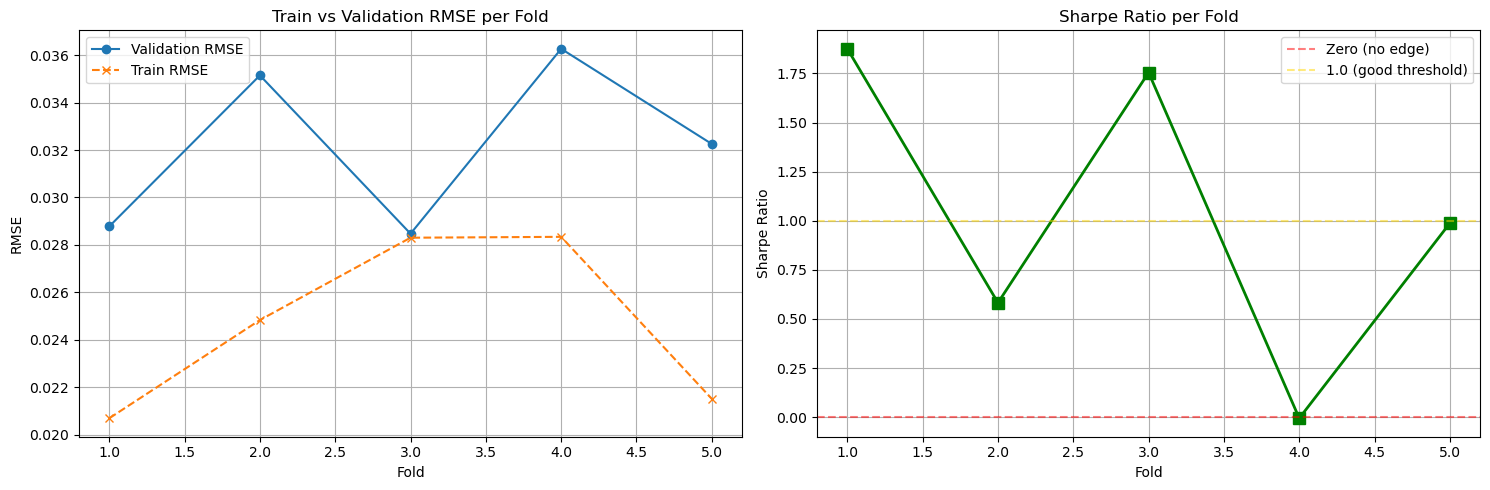

Average RMSE Gap (Validation - Train): 0.0075

--- Overall Metrics ---
Return volatility: 0.0323
Average up/down accuracy across all folds: 52.10%
Average Sharpe ratio across all folds: 1.039
Average validation RMSE across all folds: 0.0322
Validation RMSE < Validation Std Dev: 3/5 folds
([0.028778991963963867, 0.03514972936712199, 0.028470559307827895, 0.0362700123034193, 0.032255203073146665], <lightgbm.basic.Booster object at 0x1338400e0>)


In [7]:
# Testing model with extra features
X_2 = nvda_enhanced.drop(columns=['Return', 'Close', 'High', 'Low', 'Open'])
y_2 = nvda_enhanced['Return']

print(train_lgb_model(X_2, y_2))


Even more improvement! Lets keep going and add some market data

In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

def add_market_metrics_simple(nvda_df, start_date='2015-01-01'):
    """
    Simple, working version that handles timezone issues
    """
    # Create a copy
    df = nvda_df.copy()
    
    # Remove timezone from index if present
    if df.index.tz is not None:
        df.index = df.index.tz_localize(None)
    
    print(f"Working with NVDA data: shape {df.shape}")
    print(f"Date range: {df.index[0]} to {df.index[-1]}")
    
    # Ensure we have returns
    if 'Return' not in df.columns:
        df['Return'] = df['Close'].pct_change()
    
    # Define tickers
    tickers = {
        'SP500': 'SPY',
        'NASDAQ': 'QQQ',
        'TECH': 'XLK',
        'SEMICOND': 'SOXX',
        'AMD': 'AMD',
        'INTEL': 'INTC',
        'TSM': 'TSM',
        'BROADCOM': 'AVGO',
        'MICROSOFT': 'MSFT',
        'GOOGLE': 'GOOGL',
        'AMAZON': 'AMZN',
        'META': 'META',
        'APPLE': 'AAPL',
        'VIX': '^VIX',
        'GOLD': 'GLD',
        'BONDS': 'TLT',
    }
    
    # Download all tickers at once
    print("\nDownloading market data...")
    ticker_list = list(tickers.values())
    
    # Download all at once to ensure consistent timezone handling
    all_data = yf.download(ticker_list, start=start_date, progress=False, group_by='ticker')
    
    # If only one ticker downloaded, yfinance doesn't group by ticker
    if len(ticker_list) == 1:
        market_data = {tickers[list(tickers.keys())[0]]: all_data}
    else:
        market_data = {}
        for name, ticker in tickers.items():
            try:
                if ticker in all_data.columns.levels[0]:
                    ticker_data = all_data[ticker]
                    # Remove timezone if present
                    if ticker_data.index.tz is not None:
                        ticker_data.index = ticker_data.index.tz_localize(None)
                    market_data[name] = ticker_data
                    print(f"  ✓ {name} ({ticker})")
            except:
                try:
                    # Fallback for single level columns
                    ticker_data = all_data
                    if ticker_data.index.tz is not None:
                        ticker_data.index = ticker_data.index.tz_localize(None)
                    market_data[name] = ticker_data
                except:
                    print(f"  ✗ {name} ({ticker})")
    
    print(f"\nSuccessfully loaded {len(market_data)} datasets")
    
    features_added = []
    
    # 1. CORRELATIONS
    print("\nCalculating correlations...")
    for asset in ['SP500', 'NASDAQ', 'TECH', 'SEMICOND', 'AMD', 'INTEL']:
        if asset in market_data:
            try:
                # Get asset returns
                asset_close = market_data[asset]['Close']
                asset_returns = asset_close.pct_change()
                
                # Merge with NVDA returns
                merged = pd.DataFrame({
                    'nvda': df['Return'],
                    'asset': asset_returns
                })
                
                # Calculate correlations
                for period in [20, 60, 120]:
                    col_name = f'{asset}_Corr_{period}d'
                    df[col_name] = merged['nvda'].rolling(window=period, min_periods=min(period//2, 20)).corr(merged['asset'])
                    features_added.append(col_name)
                
                print(f"  ✓ {asset}: 3 correlation features")
                
            except Exception as e:
                print(f"  ✗ {asset}: {str(e)[:40]}")
    
    # 2. BETAS
    print("\nCalculating betas...")
    for index in ['SP500', 'NASDAQ', 'TECH']:
        if index in market_data:
            try:
                index_close = market_data[index]['Close']
                index_returns = index_close.pct_change()
                
                # Merge with NVDA
                merged = pd.DataFrame({
                    'nvda': df['Return'],
                    'index': index_returns
                })
                
                for period in [60, 120]:
                    col_name = f'{index}_Beta_{period}d'
                    
                    covariance = merged['nvda'].rolling(window=period, min_periods=30).cov(merged['index'])
                    variance = merged['index'].rolling(window=period, min_periods=30).var()
                    
                    df[col_name] = covariance / variance
                    features_added.append(col_name)
                
                print(f"  ✓ {index}: 2 beta features")
                
            except Exception as e:
                print(f"  ✗ {index}: {str(e)[:40]}")
    
    # 3. RELATIVE STRENGTH
    print("\nCalculating relative strength...")
    for asset in ['SP500', 'NASDAQ', 'TECH', 'AMD']:
        if asset in market_data:
            try:
                asset_close = market_data[asset]['Close']
                
                # Merge prices
                merged = pd.DataFrame({
                    'nvda': df['Close'],
                    'asset': asset_close
                })
                
                col_name = f'{asset}_RelStrength'
                df[col_name] = merged['nvda'] / merged['asset']
                features_added.append(col_name)
                
                # Momentum
                for period in [5, 10, 20]:
                    mom_col = f'{asset}_RelStrength_Mom{period}'
                    df[mom_col] = df[col_name].pct_change(period)
                    features_added.append(mom_col)
                
                print(f"  ✓ {asset}: 4 relative strength features")
                
            except Exception as e:
                print(f"  ✗ {asset}: {str(e)[:40]}")
    
    # 4. VIX
    if 'VIX' in market_data:
        try:
            vix_close = market_data['VIX']['Close']
            
            # Direct assignment with index alignment
            df['VIX_Level'] = vix_close
            df['VIX_MA20'] = vix_close.rolling(20, min_periods=10).mean()
            df['VIX_Above_MA'] = (vix_close > vix_close.rolling(20, min_periods=10).mean()).astype(int)
            
            # Handle NaN in std calculation
            vix_mean = vix_close.rolling(60, min_periods=30).mean()
            vix_std = vix_close.rolling(60, min_periods=30).std()
            df['VIX_Zscore'] = (vix_close - vix_mean) / vix_std
            
            features_added.extend(['VIX_Level', 'VIX_MA20', 'VIX_Above_MA', 'VIX_Zscore'])
            print(f"  ✓ VIX: 4 features")
            
        except Exception as e:
            print(f"  ✗ VIX: {str(e)[:40]}")
    
    # 5. TSM
    if 'TSM' in market_data:
        try:
            tsm_close = market_data['TSM']['Close']
            tsm_returns = tsm_close.pct_change()
            
            for period in [5, 10, 20]:
                col_name = f'TSM_Momentum_{period}d'
                df[col_name] = tsm_returns.rolling(period, min_periods=min(period, 5)).mean() * (252/period)
                features_added.append(col_name)
            
            # TSM relative strength
            df['TSM_RelStrength'] = df['Close'] / tsm_close
            features_added.append('TSM_RelStrength')
            
            print(f"  ✓ TSM: 4 features")
            
        except Exception as e:
            print(f"  ✗ TSM: {str(e)[:40]}")
    
    # 6. Customer Index
    customers = ['MICROSOFT', 'GOOGLE', 'AMAZON', 'META', 'APPLE']
    customer_returns = []
    
    for customer in customers:
        if customer in market_data:
            try:
                cust_close = market_data[customer]['Close']
                customer_returns.append(cust_close.pct_change())
            except:
                pass
    
    if len(customer_returns) >= 2:
        try:
            # Stack all customer returns
            customer_df = pd.concat(customer_returns, axis=1)
            
            # Calculate mean
            customer_index = customer_df.mean(axis=1)
            
            df['Customer_Index_Return'] = customer_index
            df['Customer_Index_Mom_20d'] = customer_index.rolling(20, min_periods=10).mean() * (252/20)
            df['Customer_Index_Mom_60d'] = customer_index.rolling(60, min_periods=30).mean() * (252/60)
            
            features_added.extend(['Customer_Index_Return', 'Customer_Index_Mom_20d', 'Customer_Index_Mom_60d'])
            print(f"  ✓ Customer Index: 3 features ({len(customer_returns)} stocks)")
            
        except Exception as e:
            print(f"  ✗ Customer Index: {str(e)[:40]}")
    
    # 7. Tech vs Market
    if 'TECH' in market_data and 'SP500' in market_data:
        try:
            tech_ret = market_data['TECH']['Close'].pct_change()
            spy_ret = market_data['SP500']['Close'].pct_change()
            
            for period in [20, 60]:
                tech_perf = (1 + tech_ret).rolling(period, min_periods=10).apply(lambda x: x.prod() - 1)
                spy_perf = (1 + spy_ret).rolling(period, min_periods=10).apply(lambda x: x.prod() - 1)
                
                col_name = f'Tech_vs_Market_{period}d'
                df[col_name] = tech_perf - spy_perf
                features_added.append(col_name)
            
            print(f"  ✓ Tech vs Market: 2 features")
            
        except Exception as e:
            print(f"  ✗ Tech vs Market: {str(e)[:40]}")
    
    # 8. Market Breadth (Large vs Small cap)
    if 'SP500' in market_data and 'RUSSELL' in market_data:
        try:
            # Download Russell 2000
            iwm = yf.download('IWM', start=start_date, progress=False)
            if iwm.index.tz is not None:
                iwm.index = iwm.index.tz_localize(None)
            
            spy_ret = market_data['SP500']['Close'].pct_change()
            iwm_ret = iwm['Close'].pct_change()
            
            for period in [20, 60]:
                spy_perf = (1 + spy_ret).rolling(period, min_periods=10).apply(lambda x: x.prod() - 1)
                iwm_perf = (1 + iwm_ret).rolling(period, min_periods=10).apply(lambda x: x.prod() - 1)
                
                col_name = f'LargeCap_vs_SmallCap_{period}d'
                df[col_name] = spy_perf - iwm_perf
                features_added.append(col_name)
            
            print(f"  ✓ Market Breadth: 2 features")
            
        except Exception as e:
            print(f"  ✗ Market Breadth: {str(e)[:40]}")
    
    print(f"\n{'='*60}")
    print(f"✅ SUCCESSFULLY ADDED {len(features_added)} FEATURES")
    print(f"{'='*60}")
    
    if features_added:
        print(f"\nFeatures added:")
        categories = {
            'Correlations': [f for f in features_added if 'Corr' in f],
            'Betas': [f for f in features_added if 'Beta' in f],
            'Relative Strength': [f for f in features_added if 'RelStrength' in f],
            'VIX': [f for f in features_added if 'VIX' in f],
            'TSM': [f for f in features_added if 'TSM' in f],
            'Customer': [f for f in features_added if 'Customer' in f],
            'Market Structure': [f for f in features_added if any(x in f for x in ['Tech_vs_Market', 'LargeCap'])]
        }
        
        for category, feats in categories.items():
            if feats:
                print(f"\n{category}: {len(feats)} features")
                for f in feats[:3]:
                    print(f"  - {f}")
                if len(feats) > 3:
                    print(f"  ... and {len(feats)-3} more")
    
    return df, features_added

# Run it
print("Adding market metrics to NVDA...")
nvda_market, new_features = add_market_metrics_simple(nvda_enhanced)

print(f"\nFINAL RESULTS:")
print(f"Original shape: {nvda_enhanced.shape}")
print(f"Enhanced shape: {nvda_market.shape}")
print(f"Total new features: {len(new_features)}")

# Verify data exists
if new_features:
    print(f"\nData verification (non-null counts):")
    for feat in new_features[:5]:
        non_null = nvda_market[feat].notna().sum()
        pct = (non_null / len(nvda_market)) * 100
        print(f"  {feat}: {non_null:,} ({pct:.1f}%)")

Adding market metrics to NVDA...
Working with NVDA data: shape (2661, 143)
Date range: 2015-01-30 00:00:00 to 2025-08-28 00:00:00



  ✓ SP500 (SPY)
  ✓ NASDAQ (QQQ)
  ✓ TECH (XLK)
  ✓ SEMICOND (SOXX)
  ✓ AMD (AMD)
  ✓ INTEL (INTC)
  ✓ TSM (TSM)
  ✓ BROADCOM (AVGO)
  ✓ MICROSOFT (MSFT)
  ✓ GOOGLE (GOOGL)
  ✓ AMAZON (AMZN)
  ✓ META (META)
  ✓ APPLE (AAPL)
  ✓ VIX (^VIX)
  ✓ GOLD (GLD)
  ✓ BONDS (TLT)

Successfully loaded 16 datasets

Calculating correlations...
  ✓ SP500: 3 correlation features
  ✓ NASDAQ: 3 correlation features
  ✓ TECH: 3 correlation features
  ✓ SEMICOND: 3 correlation features
  ✓ AMD: 3 correlation features
  ✓ INTEL: 3 correlation features

Calculating betas...
  ✓ SP500: 2 beta features
  ✓ NASDAQ: 2 beta features
  ✓ TECH: 2 beta features

Calculating relative strength...
  ✓ SP500: 4 relative strength features
  ✓ NASDAQ: 4 relative strength features
  ✓ TECH: 4 relative strength features
  ✓ AMD: 4 relative strength features
  ✓ VIX: 4 features
  ✓ TSM: 4 features
  ✓ Customer Index: 3 features (5 stocks)
  ✓ Tech vs Market: 2 features

✅ SUCCESSFULLY ADDED 53 FEATURES

Features added:

Cor

['AMD_Corr_20d', 'AMD_RelStrength_Mom20', 'NASDAQ_Beta_120d', 'Tech_vs_Market_60d', 'INTEL_Corr_20d', 'NASDAQ_RelStrength_Mom20', 'AMD_Corr_120d', 'INTEL_Corr_120d', 'NASDAQ_Beta_60d', 'SP500_Corr_20d', 'SP500_RelStrength', 'VIX_Zscore', 'AMD_RelStrength_Mom5', 'NASDAQ_Corr_120d', 'SP500_Corr_60d', 'NASDAQ_Corr_60d', 'TECH_Corr_20d', 'TECH_Beta_60d', 'TSM_Momentum_10d', 'SP500_RelStrength_Mom5', 'AMD_RelStrength', 'TECH_RelStrength_Mom5', 'SEMICOND_Corr_20d', 'NASDAQ_RelStrength_Mom10', 'NASDAQ_Corr_20d', 'NASDAQ_RelStrength', 'VIX_Level', 'SP500_Beta_120d', 'AMD_RelStrength_Mom10', 'SP500_Beta_60d', 'TSM_Momentum_5d', 'TECH_RelStrength', 'TSM_Momentum_20d', 'SP500_Corr_120d', 'TSM_RelStrength', 'NASDAQ_RelStrength_Mom5', 'SEMICOND_Corr_120d', 'Customer_Index_Mom_20d', 'Customer_Index_Return', 'TECH_RelStrength_Mom10', 'Tech_vs_Market_20d', 'Customer_Index_Mom_60d', 'VIX_Above_MA', 'TECH_Corr_120d', 'AMD_Corr_60d', 'SEMICOND_Corr_60d', 'SP500_RelStrength_Mom20', 'SP500_RelStrength_Mom1

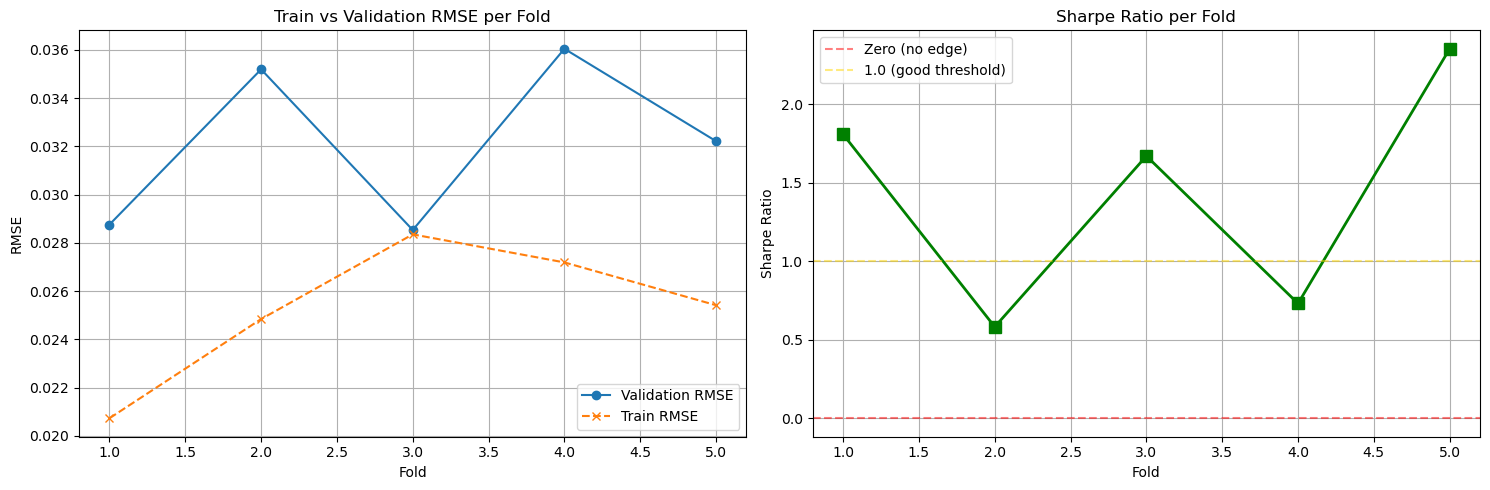

Average RMSE Gap (Validation - Train): 0.0068

--- Overall Metrics ---
Return volatility: 0.0323
Average up/down accuracy across all folds: 54.09%
Average Sharpe ratio across all folds: 1.430
Average validation RMSE across all folds: 0.0322
Validation RMSE < Validation Std Dev: 3/5 folds
([0.02876175865527814, 0.03519637809589014, 0.028534184496016694, 0.03604808876076944, 0.03221905468327347], <lightgbm.basic.Booster object at 0x13398a3c0>)


In [9]:
print(list(set(nvda_market.columns) - set(nvda_enhanced.columns)))
print(nvda_market.columns.tolist())

# Testing model with extra features
X_3 = nvda_market.drop(columns=['Return', 'Close', 'High', 'Low', 'Open'])
y_3 = nvda_market['Return']

print(train_lgb_model(X_3, y_3))

More features!!

In [10]:
from datetime import timedelta

def add_enhanced_features(nvda_market):
    """
    Add enhanced features to NVDA dataset for return prediction
    """
    df = nvda_market.copy()
    
    # Ensure date index
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    
    print("Adding enhanced features...")
    
    # =============================================================================
    # 1. OPTIONS/DERIVATIVES FEATURES (using VIX as proxy where direct options unavailable)
    # =============================================================================
    
    try:
        # VIX derivatives (you already have some VIX features, adding more)
        if 'VIX_Level' in df.columns:
            # VIX term structure proxy
            df['VIX_Momentum_5d'] = df['VIX_Level'].pct_change(5)
            df['VIX_Momentum_10d'] = df['VIX_Level'].pct_change(10)
            df['VIX_Mean_Reversion'] = (df['VIX_Level'] - df['VIX_Level'].rolling(60).mean()) / df['VIX_Level'].rolling(60).std()
            
        # Technology sector volatility proxy
        tech_etf = yf.download('XLK', start=df.index[0], end=df.index[-1] + timedelta(days=1))
        if not tech_etf.empty:
            tech_returns = tech_etf['Close'].pct_change()
            tech_vol = tech_returns.rolling(20).std() * np.sqrt(252)
            df['TECH_Implied_Vol_Proxy'] = tech_vol.reindex(df.index, method='ffill')
            df['TECH_Vol_Risk_Premium'] = df.get('Volatility10', 0) - df['TECH_Implied_Vol_Proxy']
    except Exception as e:
        print(f"Options features error: {e}")
    
    # =============================================================================
    # 2. FUNDAMENTAL/EARNINGS FEATURES
    # =============================================================================
    
    # Earnings cycle features (quarterly pattern)
    df['Quarter'] = df.index.quarter
    df['Month_in_Quarter'] = ((df.index.month - 1) % 3) + 1
    df['Days_Since_Quarter_Start'] = (df.index - df.index.to_period('Q').start_time).days
    
    # Typical earnings seasons (most tech companies report in these periods)
    df['In_Earnings_Season'] = ((df.index.month.isin([1, 4, 7, 10])) & 
                               (df.index.day >= 15) & (df.index.day <= 31)).astype(int)
    
    # =============================================================================
    # 3. SECTOR-SPECIFIC FEATURES
    # =============================================================================
    
    try:
        # Crypto features (GPU demand proxy)
        btc = yf.download('BTC-USD', start=df.index[0], end=df.index[-1] + timedelta(days=1))
        if not btc.empty:
            btc_returns = btc['Close'].pct_change()
            df['BTC_Return'] = btc_returns.reindex(df.index, method='ffill')
            df['BTC_Volatility_10d'] = btc_returns.rolling(10).std().reindex(df.index, method='ffill')
            df['BTC_Momentum_20d'] = btc['Close'].pct_change(20).reindex(df.index, method='ffill')

        eth = yf.download('ETH-USD', start=df.index[0], end=df.index[-1] + timedelta(days=1))
        if not eth.empty:
            eth_returns = eth['Close'].pct_change()
            df['ETH_Return'] = eth_returns.reindex(df.index, method='ffill')
            df['Crypto_Basket_Return'] = (df.get('BTC_Return', 0) + df['ETH_Return']) / 2
    except Exception as e:
        print(f"Crypto features error: {e}")
    
    try:
        # Gaming sector (GPU demand)
        gaming_etf = yf.download('GAMR', start=df.index[0], end=df.index[-1] + timedelta(days=1))
        if not gaming_etf.empty:
            gaming_returns = gaming_etf['Close'].pct_change()
            df['Gaming_Sector_Return'] = gaming_returns.reindex(df.index, method='ffill')
            df['Gaming_Momentum_10d'] = gaming_etf['Close'].pct_change(10).reindex(df.index, method='ffill')
    except Exception as e:
        print(f"Gaming features error: {e}")
    
    try:
        # Cloud computing sector
        cloud_etf = yf.download('CLOU', start=df.index[0], end=df.index[-1] + timedelta(days=1))
        if not cloud_etf.empty:
            cloud_returns = cloud_etf['Close'].pct_change()
            df['Cloud_Sector_Return'] = cloud_returns.reindex(df.index, method='ffill')
            df['Cloud_Momentum_20d'] = cloud_etf['Close'].pct_change(20).reindex(df.index, method='ffill')
    except Exception as e:
        print(f"Cloud features error: {e}")
    
    try:
        # Data center REITs
        datacenter_etf = yf.download('VNQ', start=df.index[0], end=df.index[-1] + timedelta(days=1))  # Using broader REIT as proxy
        if not datacenter_etf.empty:
            dc_returns = datacenter_etf['Close'].pct_change()
            df['DataCenter_Proxy_Return'] = dc_returns.reindex(df.index, method='ffill')
    except Exception as e:
        print(f"Data center features error: {e}")
    
    try:
        # Memory/Storage sector
        memory_stocks = ['MU', 'WDC']  # Micron, Western Digital as memory proxies
        memory_returns = []
        for stock in memory_stocks:
            stock_data = yf.download(stock, start=df.index[0], end=df.index[-1] + timedelta(days=1))
            if not stock_data.empty:
                memory_returns.append(stock_data['Close'].pct_change())

        if memory_returns:
            memory_basket = pd.concat(memory_returns, axis=1).mean(axis=1)
            df['Memory_Sector_Return'] = memory_basket.reindex(df.index, method='ffill')
            df['Memory_Momentum_10d'] = pd.concat([yf.download(s, start=df.index[0], end=df.index[-1] + timedelta(days=1))['Close'] 
                                                  for s in memory_stocks], axis=1).mean(axis=1).pct_change(10).reindex(df.index, method='ffill')
    except Exception as e:
        print(f"Memory sector features error: {e}")
    
    # =============================================================================
    # 4. MACRO/ECONOMIC FEATURES
    # =============================================================================
    
    try:
        # Dollar strength (DXY)
        dxy = yf.download('DX-Y.NYB', start=df.index[0], end=df.index[-1] + timedelta(days=1))
        if not dxy.empty:
            dxy_returns = dxy['Close'].pct_change()
            df['DXY_Return'] = dxy_returns.reindex(df.index, method='ffill')
            df['DXY_Momentum_10d'] = dxy['Close'].pct_change(10).reindex(df.index, method='ffill')
            dxy_ma20 = dxy['Close'].rolling(20).mean().reindex(df.index, method='ffill')
            df['DXY_MA20'] = dxy_ma20
            df['DXY_Above_MA'] = (dxy['Close'].reindex(df.index, method='ffill') > dxy_ma20).astype(int)
    except Exception as e:
        print(f"DXY features error: {e}")
    
    try:
        # 10-Year Treasury
        tnx = yf.download('^TNX', start=df.index[0], end=df.index[-1] + timedelta(days=1))
        if not tnx.empty:
            df['TNX_Level'] = tnx['Close'].reindex(df.index, method='ffill')
            df['TNX_Change'] = tnx['Close'].diff().reindex(df.index, method='ffill')
            df['TNX_Momentum_5d'] = tnx['Close'].pct_change(5).reindex(df.index, method='ffill')
            df['TNX_Volatility_10d'] = tnx['Close'].pct_change().rolling(10).std().reindex(df.index, method='ffill')
    except Exception as e:
        print(f"Treasury features error: {e}")
    
    try:
        # High-yield credit spreads proxy (HYG vs TLT)
        hyg = yf.download('HYG', start=df.index[0], end=df.index[-1] + timedelta(days=1))
        tlt = yf.download('TLT', start=df.index[0], end=df.index[-1] + timedelta(days=1))
        if not hyg.empty and not tlt.empty:
            hyg_returns = hyg['Close'].pct_change().reindex(df.index, method='ffill')
            tlt_returns = tlt['Close'].pct_change().reindex(df.index, method='ffill')
            df['Credit_Spread_Proxy'] = hyg_returns - tlt_returns
            df['Credit_Risk_Appetite'] = df['Credit_Spread_Proxy'].rolling(20).mean() 
    except Exception as e:
        print(f"Credit spread features error: {e}")
    
    try:
        # Copper (semiconductor demand proxy)
        copper = yf.download('HG=F', start=df.index[0], end=df.index[-1] + timedelta(days=1))
        if not copper.empty:
            copper_returns = copper['Close'].pct_change()
            df['Copper_Return'] = copper_returns.reindex(df.index, method='ffill')
            df['Copper_Momentum_10d'] = copper['Close'].pct_change(10).reindex(df.index, method='ffill')
    except Exception as e:
        print(f"Copper features error: {e}")
    
    # =============================================================================
    # 5. MARKET MICROSTRUCTURE FEATURES
    # =============================================================================
    
    # Intraday volatility patterns (if OHLC available)
    if all(col in df.columns for col in ['Open', 'High', 'Low', 'Close']):
        df['Intraday_Return'] = (df['Close'] - df['Open']) / df['Open']
        df['Overnight_Return'] = (df['Open'] - df['Close'].shift(1)) / df['Close'].shift(1)
        df['Gap_Size'] = abs(df['Overnight_Return'])
        df['Intraday_Volatility'] = (df['High'] - df['Low']) / df['Open']
        df['Close_Position'] = (df['Close'] - df['Low']) / (df['High'] - df['Low'])
        
        # Volatility regime
        df['Vol_Regime_High'] = (df['Intraday_Volatility'] > df['Intraday_Volatility'].rolling(60).quantile(0.8)).astype(int)
        df['Vol_Regime_Low'] = (df['Intraday_Volatility'] < df['Intraday_Volatility'].rolling(60).quantile(0.2)).astype(int)
    
    # Volume patterns
    if 'Volume' in df.columns:
        df['Volume_MA20'] = df['Volume'].rolling(20).mean()
        df['Volume_Spike'] = (df['Volume'] > 2 * df['Volume_MA20']).astype(int)
        df['Volume_Drought'] = (df['Volume'] < 0.5 * df['Volume_MA20']).astype(int)
        df['Volume_Momentum_5d'] = df['Volume'].pct_change(5)
    
    # =============================================================================
    # 6. TEMPORAL/CALENDAR FEATURES
    # =============================================================================
    
    # Calendar effects
    df['Day_of_Week'] = df.index.dayofweek
    df['Is_Monday'] = (df['Day_of_Week'] == 0).astype(int)
    df['Is_Friday'] = (df['Day_of_Week'] == 4).astype(int)
    df['Is_Month_End'] = (df.index.day >= 28).astype(int)  # Last few days of month
    df['Is_Quarter_End'] = ((df.index.month.isin([3, 6, 9, 12])) & (df.index.day >= 28)).astype(int)
    df['Is_Year_End'] = ((df.index.month == 12) & (df.index.day >= 20)).astype(int)
    
    # Options expiration (3rd Friday approximation)
    df['Days_to_OpEx'] = np.nan
    for i in range(len(df)):
        date = df.index[i]
        # Find 3rd Friday of the month
        third_friday = pd.date_range(start=date.replace(day=1), 
                                   end=date.replace(day=28), 
                                   freq='W-FRI')[2] if len(pd.date_range(start=date.replace(day=1), 
                                                                        end=date.replace(day=28), 
                                                                        freq='W-FRI')) >= 3 else None
        if third_friday:
            df.loc[df.index[i], 'Days_to_OpEx'] = (third_friday - date).days
    
    df['Near_OpEx'] = (abs(df['Days_to_OpEx']) <= 2).astype(int)
    
    # Holiday effects (simplified)
    df['Is_Holiday_Week'] = 0  # You can enhance this with actual holiday calendar
    
    # =============================================================================
    # 7. CROSS-CORRELATIONS AND INTERACTIONS
    # =============================================================================
    
    # Create interaction terms with existing features
    if 'VIX_Zscore' in df.columns and 'TECH_RelStrength' in df.columns:
        df['VIX_Tech_Interaction'] = df['VIX_Zscore'] * df['TECH_RelStrength']
    
    if 'Volume_Change' in df.columns and 'Return_1' in df.columns:
        df['Volume_Return_Interaction'] = df['Volume_Change'] * abs(df['Return_1'])
    
    # Regime-based features
    if 'VIX_Level' in df.columns:
        vix_median = df['VIX_Level'].rolling(252).median()
        df['High_VIX_Regime'] = (df['VIX_Level'] > vix_median).astype(int)
        
        # Performance in different VIX regimes
        if 'Return_1' in df.columns:
            df['Return_in_High_VIX'] = df['Return_1'] * df['High_VIX_Regime']
            df['Return_in_Low_VIX'] = df['Return_1'] * (1 - df['High_VIX_Regime'])
    
    # =============================================================================
    # 8. ADDITIONAL TECHNICAL FEATURES
    # =============================================================================
    
    if 'Close' in df.columns:
        # Fibonacci retracement levels (using 60-day high/low)
        df['High_60d'] = df['High'].rolling(60).max() if 'High' in df.columns else df['Close'].rolling(60).max()
        df['Low_60d'] = df['Low'].rolling(60).min() if 'Low' in df.columns else df['Close'].rolling(60).min()
        fib_range = df['High_60d'] - df['Low_60d']
        df['Fib_382'] = df['High_60d'] - 0.382 * fib_range
        df['Fib_618'] = df['High_60d'] - 0.618 * fib_range
        df['Near_Fib_382'] = (abs(df['Close'] - df['Fib_382']) / df['Close'] < 0.02).astype(int)
        df['Near_Fib_618'] = (abs(df['Close'] - df['Fib_618']) / df['Close'] < 0.02).astype(int)
        
        # Support/Resistance levels
        df['Distance_to_High_60d'] = (df['Close'] - df['High_60d']) / df['High_60d']
        df['Distance_to_Low_60d'] = (df['Close'] - df['Low_60d']) / df['Low_60d']
        
        # Trend strength
        df['Trend_Strength_20d'] = df['Close'].rolling(20).apply(lambda x: np.corrcoef(range(len(x)), x)[0,1])
    
    # Clean up any infinite or extremely large values
    df = df.replace([np.inf, -np.inf], np.nan)
    
    print(f"Added {len(df.columns) - len(nvda_market.columns)} new features")
    print("New features added:")
    new_features = [col for col in df.columns if col not in nvda_market.columns]
    for feature in sorted(new_features):
        print(f"  - {feature}")
    
    return df

# Usage example:
nvda_3 = add_enhanced_features(nvda_market)

print(list(set(nvda_3.columns) - set(nvda_market.columns)))

Adding enhanced features...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Credit spread features error: Cannot set a DataFrame with multiple columns to the single column Credit_Spread_Proxy


[*********************100%***********************]  1 of 1 completed


Added 65 new features
New features added:
  - BTC_Momentum_20d
  - BTC_Return
  - BTC_Volatility_10d
  - Close_Position
  - Cloud_Momentum_20d
  - Cloud_Sector_Return
  - Copper_Momentum_10d
  - Copper_Return
  - Crypto_Basket_Return
  - DXY_Above_MA
  - DXY_MA20
  - DXY_Momentum_10d
  - DXY_Return
  - DataCenter_Proxy_Return
  - Day_of_Week
  - Days_Since_Quarter_Start
  - Days_to_OpEx
  - Distance_to_High_60d
  - Distance_to_Low_60d
  - ETH_Return
  - Fib_382
  - Fib_618
  - Gaming_Momentum_10d
  - Gaming_Sector_Return
  - Gap_Size
  - High_60d
  - High_VIX_Regime
  - In_Earnings_Season
  - Intraday_Return
  - Intraday_Volatility
  - Is_Friday
  - Is_Holiday_Week
  - Is_Monday
  - Is_Month_End
  - Is_Quarter_End
  - Is_Year_End
  - Low_60d
  - Memory_Momentum_10d
  - Memory_Sector_Return
  - Month_in_Quarter
  - Near_Fib_382
  - Near_Fib_618
  - Near_OpEx
  - Overnight_Return
  - Quarter
  - Return_in_High_VIX
  - Return_in_Low_VIX
  - TECH_Implied_Vol_Proxy
  - TECH_Vol_Risk_Premium

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	valid_0's rmse: 0.028738
Fold 1 - Train RMSE: 0.0202 | Validation RMSE: 0.0287
           Validation Std Dev: 0.0289 | Up/Down Accuracy: 54.85% | Sharpe: 1.764
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's rmse: 0.0351466
Fold 2 - Train RMSE: 0.0241 | Validation RMSE: 0.0351
           Validation Std Dev: 0.0351 | Up/Down Accuracy: 54.85% | Sharpe: 0.913
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.028681
Fold 3 - Train RMSE: 0.0283 | Validation RMSE: 0.0287
           Validation Std Dev: 0.0285 | Up/Down Accuracy: 44.02% | Sharpe: -1.270
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.036214
Fold 4 - Train RMSE: 0.0282 | Validation RMSE: 0.0362
           Validation Std Dev: 0.0361 |

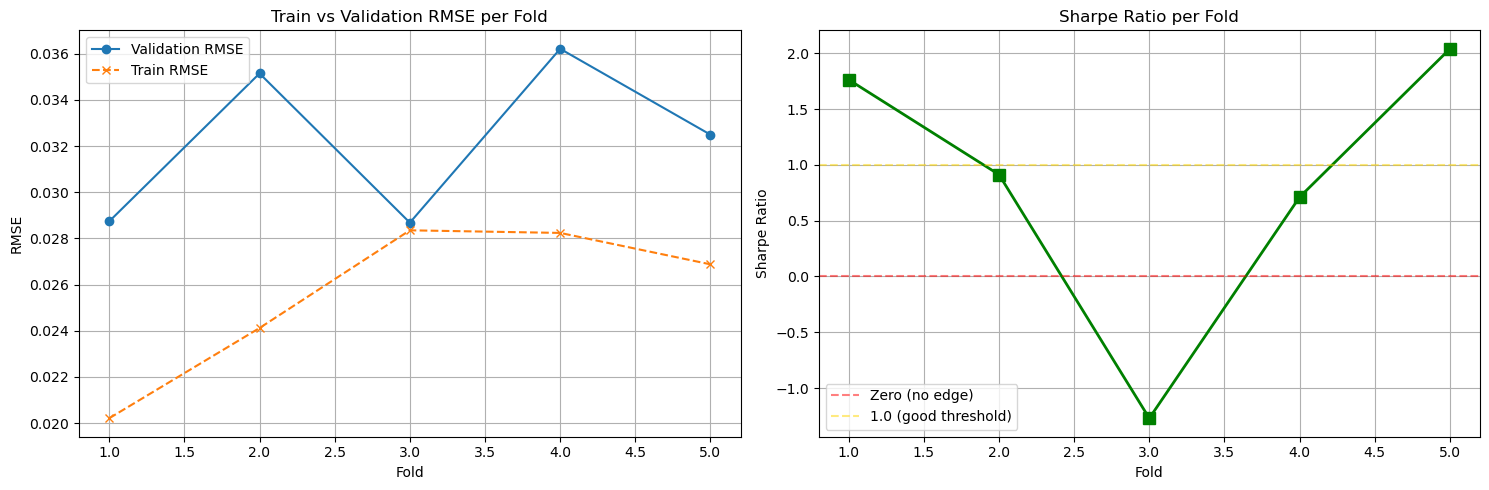

Average RMSE Gap (Validation - Train): 0.0067

--- Overall Metrics ---
Return volatility: 0.0323
Average up/down accuracy across all folds: 51.87%
Average Sharpe ratio across all folds: 0.832
Average validation RMSE across all folds: 0.0323
Validation RMSE < Validation Std Dev: 2/5 folds
([0.028737982802507923, 0.03514655076763598, 0.02868100633186607, 0.03621400386311438, 0.03249222637288422], <lightgbm.basic.Booster object at 0x1336cf3e0>)


In [11]:
# Testing model with extra features
X_4 = nvda_3.drop(columns=['Return', 'Close', 'High', 'Low', 'Open'])
y_4 = nvda_3['Return']

print(train_lgb_model(X_4, y_4))

### Final features add

In [12]:
# Additional imports for new features
try:
    from pytrends.request import TrendReq
    TRENDS_AVAILABLE = True
except ImportError:
    print("Install pytrends: pip install pytrends")
    TRENDS_AVAILABLE = False

try:
    import requests
    REQUESTS_AVAILABLE = True
except ImportError:
    print("Install requests: pip install requests")
    REQUESTS_AVAILABLE = False

def add_advanced_features(nvda_market):
    """
    Add advanced features using free Python libraries
    """
    df = nvda_market.copy()
    
    # Ensure date index
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    
    print("Adding advanced features with free libraries...")
    
    # =============================================================================
    # 1. EARNINGS CALENDAR FEATURES
    # =============================================================================
    
    try:
        print("Fetching NVDA earnings calendar...")
        nvda_ticker = yf.Ticker('NVDA')
        
        # Get earnings calendar (next few earnings)
        try:
            earnings_calendar = nvda_ticker.calendar
            if earnings_calendar is not None and len(earnings_calendar) > 0:
                next_earnings = pd.to_datetime(earnings_calendar.index[0])
                df['Days_to_Earnings'] = (next_earnings - df.index).days
                df['Within_Week_of_Earnings'] = (abs(df['Days_to_Earnings']) <= 5).astype(int)
                df['Within_2Weeks_of_Earnings'] = (abs(df['Days_to_Earnings']) <= 14).astype(int)
                print(f"Next earnings date: {next_earnings}")
            else:
                print("No earnings calendar data available")
        except Exception as e:
            print(f"Earnings calendar error: {e}")
            
        # Historical earnings pattern (quarterly approximation)
        # NVDA typically reports in Feb, May, Aug, Nov
        earnings_months = [2, 5, 8, 11]  # Feb, May, Aug, Nov
        df['Earnings_Month'] = df.index.month.isin(earnings_months).astype(int)
        
        # Days since likely last earnings (quarterly pattern)
        df['Days_Since_Last_Earnings_Est'] = np.nan
        for i, date in enumerate(df.index):
            # Find most recent earnings month
            current_month = date.month
            current_year = date.year
            
            # Find the most recent earnings month
            for j in range(4):  # Look back up to 4 quarters
                for earnings_month in sorted(earnings_months, reverse=True):
                    check_year = current_year if earnings_month <= current_month else current_year - 1
                    if j > 0:
                        check_year -= (j // 4) if earnings_month <= current_month else ((j-1) // 4)
                    
                    # Approximate earnings date (3rd week of month)
                    try:
                        earnings_date = datetime(check_year, earnings_month, 15)
                        if earnings_date <= date:
                            days_since = (date - earnings_date).days
                            df.loc[date, 'Days_Since_Last_Earnings_Est'] = days_since
                            break
                    except:
                        continue
                if not pd.isna(df.loc[date, 'Days_Since_Last_Earnings_Est']):
                    break
                    
    except Exception as e:
        print(f"Earnings features error: {e}")
    
    # =============================================================================
    # 2. BASIC OPTIONS DATA
    # =============================================================================
    
    try:
        print("Fetching NVDA options data...")
        nvda_ticker = yf.Ticker('NVDA')
        
        # Get current options data (this is a snapshot, not historical)
        try:
            options_dates = nvda_ticker.options
            if options_dates:
                # Use nearest expiration
                nearest_expiry = options_dates[0]
                option_chain = nvda_ticker.option_chain(nearest_expiry)
                
                calls = option_chain.calls
                puts = option_chain.puts
                
                if not calls.empty and not puts.empty:
                    # Calculate put/call volume ratio (current snapshot)
                    total_call_volume = calls['volume'].sum()
                    total_put_volume = puts['volume'].sum()
                    
                    if total_call_volume > 0:
                        put_call_ratio = total_put_volume / total_call_volume
                    else:
                        put_call_ratio = np.nan
                    
                    # Add as constant for recent period (since it's current snapshot)
                    df['Put_Call_Ratio_Snapshot'] = put_call_ratio
                    
                    # Calculate basic implied volatility proxy
                    # Average of ATM options implied volatility
                    current_price = df['Close'].iloc[-1] if 'Close' in df.columns else 100
                    
                    # Find ATM options (within 5% of current price)
                    atm_calls = calls[abs(calls['strike'] - current_price) / current_price <= 0.05]
                    atm_puts = puts[abs(puts['strike'] - current_price) / current_price <= 0.05]
                    
                    if not atm_calls.empty and 'impliedVolatility' in atm_calls.columns:
                        avg_iv = (atm_calls['impliedVolatility'].mean() + 
                                 atm_puts['impliedVolatility'].mean()) / 2
                        df['Implied_Vol_Snapshot'] = avg_iv
                        
                        # IV vs realized volatility
                        if 'Volatility10' in df.columns:
                            df['IV_RV_Spread'] = avg_iv - df['Volatility10']
                    
                    print(f"Put/Call Ratio: {put_call_ratio:.2f}")
                    
        except Exception as e:
            print(f"Options chain error: {e}")
            
    except Exception as e:
        print(f"Options features error: {e}")
    
    # =============================================================================
    # 3. ANALYST RECOMMENDATIONS
    # =============================================================================
    
    try:
        print("Fetching analyst recommendations...")
        nvda_ticker = yf.Ticker('NVDA')
        
        recommendations = nvda_ticker.recommendations
        if recommendations is not None and not recommendations.empty:
            # Get recent recommendations (last 90 days)
            cutoff_date = datetime.now() - timedelta(days=90)
            recent_recs = recommendations[pd.to_datetime(recommendations.index) >= cutoff_date]
            
            if not recent_recs.empty:
                # Count upgrades vs downgrades
                upgrades = recent_recs[recent_recs['To Grade'] > recent_recs['From Grade']]
                downgrades = recent_recs[recent_recs['To Grade'] < recent_recs['From Grade']]
                
                upgrade_count = len(upgrades)
                downgrade_count = len(downgrades)
                
                df['Recent_Upgrades_90d'] = upgrade_count
                df['Recent_Downgrades_90d'] = downgrade_count
                df['Net_Upgrades_90d'] = upgrade_count - downgrade_count
                df['Upgrade_Momentum'] = 1 if upgrade_count > downgrade_count else -1 if downgrade_count > upgrade_count else 0
                
                print(f"Recent analyst activity - Upgrades: {upgrade_count}, Downgrades: {downgrade_count}")
            else:
                print("No recent analyst recommendations found")
                
    except Exception as e:
        print(f"Analyst recommendations error: {e}")
    
    # =============================================================================
    # 4. GOOGLE TRENDS DATA
    # =============================================================================
    
    if TRENDS_AVAILABLE:
        try:
            print("Fetching Google Trends data...")
            pytrends = TrendReq(hl='en-US', tz=360)
            
            # Key search terms for NVIDIA
            nvidia_terms = ['NVIDIA', 'RTX 4090', 'AI chips', 'GPU mining']
            
            # Get trends for last 90 days (daily data)
            try:
                pytrends.build_payload(nvidia_terms[:1], cat=0, timeframe='today 3-m', geo='', gprop='')
                trends_data_nvidia = pytrends.interest_over_time()
                
                if not trends_data_nvidia.empty:
                    trends_data_nvidia.index = pd.to_datetime(trends_data_nvidia.index)
                    nvidia_trend = trends_data_nvidia['NVIDIA'].reindex(df.index, method='ffill')
                    
                    df['Google_Trends_NVIDIA'] = nvidia_trend
                    df['NVIDIA_Trend_MA7'] = nvidia_trend.rolling(7).mean()
                    df['NVIDIA_Trend_Momentum'] = nvidia_trend.pct_change(7)
                    df['NVIDIA_Trend_Spike'] = (nvidia_trend > nvidia_trend.rolling(30).quantile(0.9)).astype(int)
                    
                    print("Successfully added NVIDIA Google Trends")
                    
            except Exception as e:
                print(f"NVIDIA trends error: {e}")
                
            # AI-related terms
            try:
                ai_terms = ['artificial intelligence', 'machine learning']
                pytrends.build_payload(ai_terms[:1], cat=0, timeframe='today 3-m', geo='', gprop='')
                trends_data_ai = pytrends.interest_over_time()
                
                if not trends_data_ai.empty:
                    trends_data_ai.index = pd.to_datetime(trends_data_ai.index)
                    ai_trend = trends_data_ai['artificial intelligence'].reindex(df.index, method='ffill')
                    
                    df['Google_Trends_AI'] = ai_trend
                    df['AI_Trend_Momentum'] = ai_trend.pct_change(7)
                    
                    print("Successfully added AI Google Trends")
                    
            except Exception as e:
                print(f"AI trends error: {e}")
                
        except Exception as e:
            print(f"Google Trends error: {e}")
    else:
        print("Google Trends not available - install pytrends")
    
    # =============================================================================
    # 5. CRYPTO MINING PROFITABILITY
    # =============================================================================
    
    if REQUESTS_AVAILABLE:
        try:
            print("Calculating crypto mining profitability...")
            
            # Get BTC and ETH prices (already have these likely)
            btc_data = yf.download('BTC-USD', start=df.index[0], end=df.index[-1] + timedelta(days=1))
            eth_data = yf.download('ETH-USD', start=df.index[0], end=df.index[-1] + timedelta(days=1))
            
            if not btc_data.empty and not eth_data.empty:
                btc_prices = btc_data['Close'].reindex(df.index, method='ffill')
                eth_prices = eth_data['Close'].reindex(df.index, method='ffill')
                
                # Simplified mining profitability proxy
                # (This is a rough approximation - real mining profitability depends on difficulty, hash rate, etc.)
                
                # BTC mining proxy (higher BTC price = more profitable = more GPU demand for some miners)
                df['BTC_Mining_Proxy'] = btc_prices / btc_prices.rolling(30).mean()
                
                # ETH mining was more GPU-intensive (until ETH 2.0)
                df['ETH_Mining_Proxy'] = eth_prices / eth_prices.rolling(30).mean()
                
                # Combined crypto mining attractiveness
                df['Crypto_Mining_Attractiveness'] = (df['BTC_Mining_Proxy'] + df['ETH_Mining_Proxy']) / 2
                df['Mining_Trend_7d'] = df['Crypto_Mining_Attractiveness'].pct_change(7)
                
                print("Added crypto mining profitability proxies")
                
        except Exception as e:
            print(f"Crypto mining features error: {e}")
    
    # =============================================================================
    # 6. ENHANCED SECTOR ROTATION FEATURES
    # =============================================================================
    
    try:
        print("Adding sector rotation features...")
        
        # Get sector ETFs for rotation analysis
        sector_etfs = {
            'Technology': 'XLK',
            'Healthcare': 'XLV', 
            'Financials': 'XLF',
            'Energy': 'XLE',
            'Consumer_Discretionary': 'XLY',
            'Industrials': 'XLI'
        }
        
        sector_returns = {}
        for sector, etf in sector_etfs.items():
            try:
                sector_data = yf.download(etf, start=df.index[0], end=df.index[-1] + timedelta(days=1))
                if not sector_data.empty:
                    sector_ret = sector_data['Close'].pct_change().reindex(df.index, method='ffill')
                    sector_returns[f'{sector}_Return'] = sector_ret
            except:
                continue
        
        if sector_returns:
            sector_df = pd.DataFrame(sector_returns, index=df.index)
            
            # Sector momentum rankings
            for period in [5, 10, 20]:
                sector_mom = sector_df.pct_change(period)
                # Tech sector ranking vs other sectors
                if 'Technology_Return' in sector_mom.columns:
                    tech_rank = sector_mom.rank(axis=1, ascending=False)['Technology_Return']
                    df[f'Tech_Sector_Rank_{period}d'] = tech_rank
                    df[f'Tech_Outperforming_{period}d'] = (tech_rank <= 2).astype(int)  # Top 2 sectors
            
            # Sector rotation indicator (when money flows between sectors)
            sector_vol = sector_df.rolling(10).std()
            if len(sector_vol.columns) > 1:
                sector_rotation = sector_vol.mean(axis=1)
                df['Sector_Rotation_Intensity'] = sector_rotation / sector_rotation.rolling(60).mean()
            
            print("Added sector rotation features")
            
    except Exception as e:
        print(f"Sector rotation features error: {e}")
    
    # =============================================================================
    # 7. ENHANCED VOLATILITY FEATURES
    # =============================================================================
    
    try:
        # VIX term structure approximation
        vix_data = yf.download('^VIX', start=df.index[0], end=df.index[-1] + timedelta(days=1))
        vix9d_data = yf.download('^VIX9D', start=df.index[0], end=df.index[-1] + timedelta(days=1))
        
        if not vix_data.empty and not vix9d_data.empty:
            vix = vix_data['Close'].reindex(df.index, method='ffill')
            vix9d = vix9d_data['Close'].reindex(df.index, method='ffill')
            
            # VIX term structure
            vix_term_structure = vix / vix9d  # Contango/backwardation
            df['VIX_Term_Structure'] = vix_term_structure
            df['VIX_Term_Structure_MA'] = vix_term_structure.rolling(20).mean()
            df['VIX_Curve_Steep'] = (vix_term_structure > 1.05).astype(int)  # Steep contango
            df['VIX_Curve_Inverted'] = (vix_term_structure < 0.95).astype(int)  # Backwardation
            
            print("Added VIX term structure features")
            
    except Exception as e:
        print(f"VIX term structure error: {e}")
    
    # =============================================================================
    # 8. NEWS/EVENT DETECTION FEATURES
    # =============================================================================
    
    # Market stress indicators
    if 'Volume' in df.columns and 'Return' in df.columns:
        # Unusual market activity detection
        df['Volume_Price_Divergence'] = df['Volume'].rolling(5).corr(abs(df['Return']))
        df['Market_Stress_Indicator'] = ((df['Volume'] > df['Volume'].rolling(60).quantile(0.95)) & 
                                        (abs(df['Return']) > df['Return'].rolling(60).std() * 2)).astype(int)
        
        # Gap detection (potential news events)
        if 'Open' in df.columns and 'Close' in df.columns:
            overnight_gap = (df['Open'] - df['Close'].shift(1)) / df['Close'].shift(1)
            df['Large_Gap'] = (abs(overnight_gap) > overnight_gap.rolling(60).std() * 2).astype(int)
    
    # Clean up any infinite or extremely large values
    df = df.replace([np.inf, -np.inf], np.nan)
    
    print(f"Added {len(df.columns) - len(nvda_market.columns)} new advanced features")
    print("\nNew advanced features added:")
    new_features = [col for col in df.columns if col not in nvda_market.columns]
    for feature in sorted(new_features):
        print(f"  - {feature}")
    
    return df

# Usage example:
nvda_4 = add_advanced_features(nvda_3)

print(nvda_4.columns.to_list())

Adding advanced features with free libraries...
Fetching NVDA earnings calendar...
Earnings calendar error: 'dict' object has no attribute 'index'
Fetching NVDA options data...
Put/Call Ratio: 0.50
Fetching analyst recommendations...
No recent analyst recommendations found
Fetching Google Trends data...
Successfully added NVIDIA Google Trends


[*********************100%***********************]  1 of 1 completed

Successfully added AI Google Trends
Calculating crypto mining profitability...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Added crypto mining profitability proxies
Adding sector rotation features...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sector rotation features error: Data must be 1-dimensional, got ndarray of shape (2661, 1) instead


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

VIX term structure error: Cannot set a DataFrame with multiple columns to the single column VIX_Term_Structure
Added 18 new advanced features

New advanced features added:
  - AI_Trend_Momentum
  - BTC_Mining_Proxy
  - Crypto_Mining_Attractiveness
  - Days_Since_Last_Earnings_Est
  - ETH_Mining_Proxy
  - Earnings_Month
  - Google_Trends_AI
  - Google_Trends_NVIDIA
  - IV_RV_Spread
  - Implied_Vol_Snapshot
  - Large_Gap
  - Market_Stress_Indicator
  - Mining_Trend_7d
  - NVIDIA_Trend_MA7
  - NVIDIA_Trend_Momentum
  - NVIDIA_Trend_Spike
  - Put_Call_Ratio_Snapshot
  - Volume_Price_Divergence
['Close', 'High', 'Low', 'Open', 'Volume', 'Return', 'MA5', 'MA10', 'MA20', 'Volatility5', 'Volatility10', 'Momentum5', 'Momentum10', 'Close_Open', 'High_Low', 'Volume_Change', 'Return_1', 'Return_2', 'Return_3', 'Daily_Range', 'Max10', 'Min10', 'Close_to_High10', 'Close_to_Low10', 'Dev_MA5', 'Dev_MA10', 'AvgVol5', 'Vol/AvgVol5', 'RSI', 'MACD', 'Signal_Line', 'Body', 'Upper_Wick', 'Lower_Wick', 'Body

In [13]:
# Storing nvda_4 dataset
import pickle
nvda_4.to_pickle('nvda_with_features.pkl')


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's rmse: 0.0287636
Fold 1 - Train RMSE: 0.0206 | Validation RMSE: 0.0288
           Validation Std Dev: 0.0289 | Up/Down Accuracy: 55.08% | Sharpe: 1.725
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0351532
Fold 2 - Train RMSE: 0.0248 | Validation RMSE: 0.0352
           Validation Std Dev: 0.0351 | Up/Down Accuracy: 53.05% | Sharpe: 0.583
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.028681
Fold 3 - Train RMSE: 0.0284 | Validation RMSE: 0.0287
           Validation Std Dev: 0.0285 | Up/Down Accuracy: 44.02% | Sharpe: -1.270
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0362145
Fold 4 - Train RMSE: 0.0282 | Validation RMSE: 0.0362
           Validation Std Dev: 0.0361

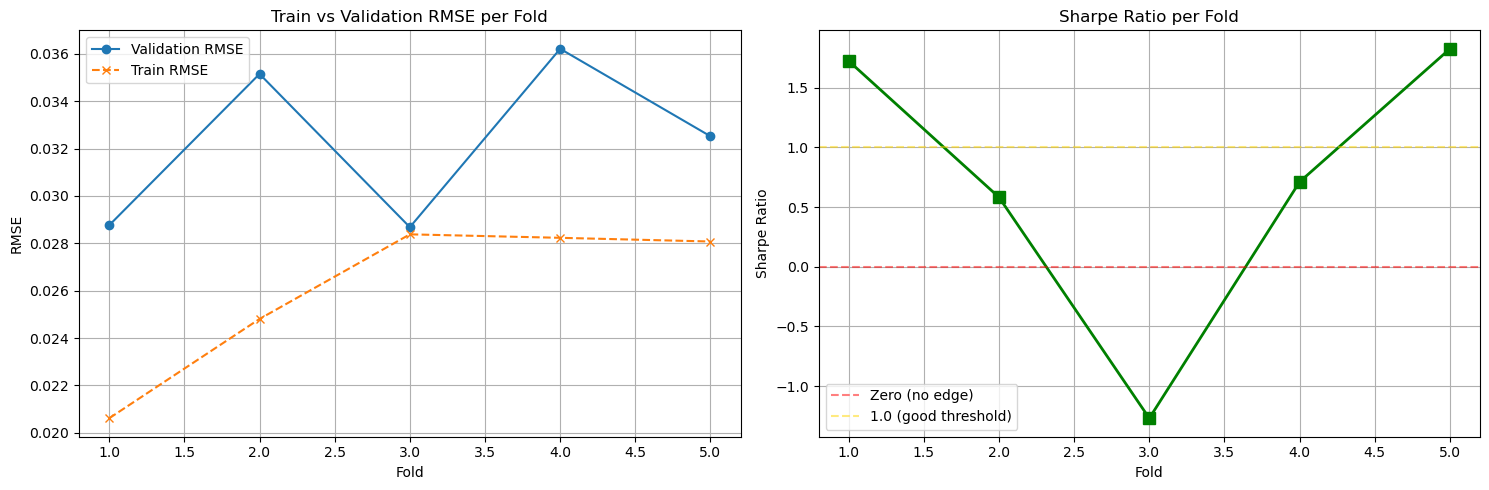

Average RMSE Gap (Validation - Train): 0.0062

--- Overall Metrics ---
Return volatility: 0.0323
Average up/down accuracy across all folds: 51.96%
Average Sharpe ratio across all folds: 0.715
Average validation RMSE across all folds: 0.0323
Validation RMSE < Validation Std Dev: 2/5 folds


In [14]:
# Testing model with extra features
X_5 = nvda_4.drop(columns=['Return'])
y_5 = nvda_4['Return']

a, model = train_lgb_model(X_5, y_5)

## Feature addition complete

There are some high ROI features we are missing still which professional firms would use however the data for these costs a lot of money to attain. For example: Real-Time Options Flow, Professional Sentiment Analysis, Supply Chain Intelligence, ...

Hence we will kove onto the next steps to improve model performance: feature importance analysis, hyperparameter tuning, ...

## Feature selection

We will start by analysing the importance of the features to the LGBM 

In [15]:
importance_df = pd.DataFrame({
    'Feature': model.feature_name(),
    'Importance': model.feature_importance()
})

# Sort by importance (ascending)
importance_df = importance_df.sort_values(by='Importance', ascending=True)

# Display the ordered list of features
print(importance_df)

print(f"Total number of features: {len(nvda_4.columns)}")

cutoffs = [1, 0.5, 0.1, 0.01, 0.001]

for cutoff in cutoffs:
    count = (importance_df['Importance'] < cutoff).sum()
    print(f"Features with importance < {cutoff}: {count}")


# Check if zero-importance features have variance
zero_importance_features = importance_df[importance_df['Importance'] == 0]['Feature'].tolist()



print(f"Features with zero variance: {(nvda_4[zero_importance_features].std() == 0).sum()}")
print(f"Features with very low variance: {(nvda_4[zero_importance_features].std() < 0.001).sum()}")

                     Feature  Importance
0                      Close           0
161          SP500_Beta_120d           0
162          NASDAQ_Beta_60d           0
163         NASDAQ_Beta_120d           0
164            TECH_Beta_60d           0
..                       ...         ...
132              Swing_Index           3
228                 Gap_Size           4
191   Customer_Index_Mom_20d           5
213  DataCenter_Proxy_Return           8
8                Volatility5          18

[278 rows x 2 columns]
Total number of features: 279
Features with importance < 1: 206
Features with importance < 0.5: 206
Features with importance < 0.1: 206
Features with importance < 0.01: 206
Features with importance < 0.001: 206
Features with zero variance: 1
Features with very low variance: 3


Basically all 0 importance features have some variance so it seems they are enetered in the dataset correctly

We will now remove all 0 importance features from our model and evaluate

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	valid_0's rmse: 0.0287479
Fold 1 - Train RMSE: 0.0181 | Validation RMSE: 0.0287
           Validation Std Dev: 0.0289 | Up/Down Accuracy: 53.27% | Sharpe: 0.622
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0352389
Fold 2 - Train RMSE: 0.0249 | Validation RMSE: 0.0352
           Validation Std Dev: 0.0351 | Up/Down Accuracy: 53.05% | Sharpe: 0.583
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	valid_0's rmse: 0.0278646
Fold 3 - Train RMSE: 0.0260 | Validation RMSE: 0.0279
           Validation Std Dev: 0.0285 | Up/Down Accuracy: 53.72% | Sharpe: 2.239
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0362492
Fold 4 - Train RMSE: 0.0283 | Validation RMSE: 0.0362
           Validation Std Dev: 0.0361

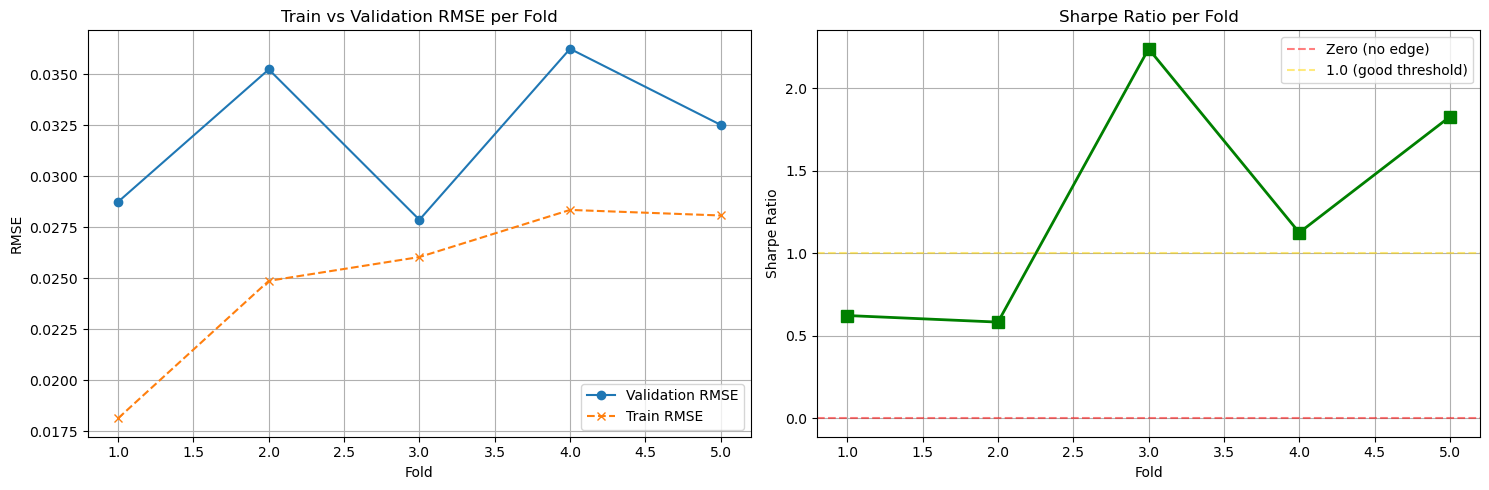

Average RMSE Gap (Validation - Train): 0.0070

--- Overall Metrics ---
Return volatility: 0.0323
Average up/down accuracy across all folds: 53.86%
Average Sharpe ratio across all folds: 1.279
Average validation RMSE across all folds: 0.0321
Validation RMSE < Validation Std Dev: 3/5 folds
([0.028747937587162407, 0.035238924613521544, 0.027864640067598475, 0.03624922432212545, 0.032519563328469066], <lightgbm.basic.Booster object at 0x133b542f0>)


In [16]:
X_6 = nvda_4.drop(columns=zero_importance_features + ['Return'])
y_6 = nvda_4['Return']

print(train_lgb_model(X_6, y_6))

Now we will look at correlations to trim features further

In [17]:
def analyze_correlations(X, threshold=0.95):
    """
    Analyze feature correlations before removal
    """
    # Calculate correlation matrix
    corr_matrix = X.corr().abs()
    
    # Get features to drop (upper triangle method)
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    features_to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
    
    # Find all high correlations for analysis
    high_corr_pairs = []
    feature_corr_counts = {}
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] >= threshold:
                feat1 = corr_matrix.columns[i]
                feat2 = corr_matrix.columns[j]
                corr_value = corr_matrix.iloc[i, j]
                
                high_corr_pairs.append({
                    'Feature_1': feat1,
                    'Feature_2': feat2,
                    'Correlation': corr_value
                })
                
                feature_corr_counts[feat1] = feature_corr_counts.get(feat1, 0) + 1
                feature_corr_counts[feat2] = feature_corr_counts.get(feat2, 0) + 1
    
    print(f"CORRELATION ANALYSIS (threshold = {threshold})")
    print("=" * 60)
    print(f"Total features: {len(X.columns)}")
    print(f"Features to remove: {len(features_to_drop)}")
    print(f"Features to keep: {len(X.columns) - len(features_to_drop)}")
    
    # IMPORTANT: Return the features_to_drop
    return features_to_drop

# Use it like this
features_to_drop = analyze_correlations(X_6, threshold=0.95)
print(features_to_drop)

X_7 = X_6.drop(columns=features_to_drop)

CORRELATION ANALYSIS (threshold = 0.95)
Total features: 72
Features to remove: 2
Features to keep: 70
['Signal_Line', 'PVI']


## Forward selection

I have now trimmed down the features to 70 based off importance and correlation.

My next step is to use backwards selection to find the feature combination that optimizes Sharpe ratio (long when predicted return > 0, short when predicted return < 0).

I chose backwards selection over forwards selection because it's faster when you have lots of features - instead of testing every possible combination from scratch, you just start with everything and cut out the junk.

Later on I will introduce a more advanced trading strategy with a threshold for long/short positions, however for now I have decided to use no threshold to avoid overfitting during feature selection.

In [18]:
def backward_selection_sharpe(X, y, n_splits=5, min_features=3, params=None):
    """
    Backward selection - MUCH faster for your case
    """
    import lightgbm as lgb
    from sklearn.model_selection import TimeSeriesSplit
    import numpy as np
    import pandas as pd
    
    if params is None:
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'verbosity': -1,
            'max_depth': 4,
            'num_leaves': 15,
            'lambda_l1': 1.0,
            'lambda_l2': 1.0,
            'min_child_samples': 50,
            'learning_rate': 0.1
        }
    
    def evaluate_features(feature_list):
        if len(feature_list) == 0:
            return 0
        
        X_subset = X[feature_list]
        tscv = TimeSeriesSplit(n_splits=n_splits)
        sharpes = []
        
        for train_idx, val_idx in tscv.split(X_subset):
            X_train, X_val = X_subset.iloc[train_idx], X_subset.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            train_data = lgb.Dataset(X_train, label=y_train)
            val_data = lgb.Dataset(X_val, label=y_val)
            
            model = lgb.train(
                params,
                train_data,
                num_boost_round=100,  # Faster for initial passes
                valid_sets=[val_data],
                callbacks=[
                    lgb.early_stopping(stopping_rounds=10),
                    lgb.log_evaluation(0)
                ]
            )
            
            val_preds = model.predict(X_val)
            positions = np.sign(val_preds)
            strategy_returns = positions * y_val
            
            if strategy_returns.std() > 0:
                sharpe = np.sqrt(252) * (strategy_returns.mean() / strategy_returns.std())
            else:
                sharpe = 0
                
            sharpes.append(sharpe)
        
        return np.mean(sharpes)
    
    # Start with all features
    current_features = list(X.columns)
    initial_sharpe = evaluate_features(current_features)
    
    selection_history = [{
        'n_features': len(current_features),
        'feature_removed': 'None',
        'sharpe': initial_sharpe
    }]
    
    print(f"Starting with all {len(current_features)} features: Sharpe = {initial_sharpe:+.6f}")
    print("="*60)
    
    while len(current_features) > min_features:
        print(f"\nRound {len(X.columns) - len(current_features) + 1}")
        print(f"Current features: {len(current_features)}")
        
        # Test removing each feature
        removal_scores = {}
        
        for feature in current_features:
            test_features = [f for f in current_features if f != feature]
            score = evaluate_features(test_features)
            removal_scores[feature] = score
            
            # Show progress
            if len(removal_scores) % 10 == 0:
                print(f"  Tested {len(removal_scores)}/{len(current_features)} removals...")
        
        # Find best removal (highest Sharpe after removal)
        best_removal = max(removal_scores, key=removal_scores.get)
        best_sharpe = removal_scores[best_removal]
        
        print(f"Best removal: {best_removal} -> Sharpe: {best_sharpe:+.6f}")
        
        # Remove it
        current_features.remove(best_removal)
        
        selection_history.append({
            'n_features': len(current_features),
            'feature_removed': best_removal,
            'sharpe': best_sharpe
        })
        
        # Stop early if Sharpe dropping significantly
        if best_sharpe < selection_history[-2]['sharpe'] - 0.1:
            print("⚠ Sharpe dropping significantly, consider stopping here")
    
    results_df = pd.DataFrame(selection_history)
    
    # Find optimal
    optimal_idx = results_df['sharpe'].idxmax()
    optimal_n = results_df.iloc[optimal_idx]['n_features']
    
    print(f"\n{'='*60}")
    print(f"Optimal: {optimal_n} features with Sharpe {results_df.iloc[optimal_idx]['sharpe']:+.6f}")
    
    return results_df

# Run backward selection - MUCH faster!
backward_results = backward_selection_sharpe(X_7, y_6, min_features=3)

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0288696
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0352013
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's rmse: 0.028076
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0360701
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 0.0325662
Starting with all 70 features: Sharpe = +1.310330

Round 1
Current features: 70
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0288696
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0352013
Training until validation scores don'

We have found the feature combination which produce the best SHARPE values via feature selection.

Now I am going to take the top 5 feature combinations and analyse them

In [19]:
# Get top 5 feature combinations with Sharpe values
top_5_results = backward_results.nlargest(5, 'sharpe').copy()
print("TOP 5 FEATURE COMBINATIONS BY SHARPE RATIO:")
print("=" * 50)

# Store feature lists
features_1, features_2, features_3, features_4, features_5 = [], [], [], [], []
feature_lists = [features_1, features_2, features_3, features_4, features_5]

for rank, (idx, row) in enumerate(top_5_results.iterrows(), 1):
    n_features = int(row['n_features'])
    sharpe = row['sharpe']
    
    # Get features that were removed UP TO AND INCLUDING this point
    features_to_remove = backward_results[backward_results.index <= idx]['feature_removed'].tolist()
    
    # Start with all features and remove the ones that were eliminated up to this point
    feature_combination = [f for f in X_7.columns if f not in features_to_remove]
    
    # Store in the appropriate variable
    feature_lists[rank-1].extend(feature_combination)
    
    print(f"{rank}: {n_features} features, Sharpe: {sharpe:+.6f}")

print(f"\nFeature lists stored as: features_1, features_2, features_3, features_4, features_5")
print(f"Best combination: {len(features_1)} features in 'features_1'")

# Quick verification
print(f"\nVerification:")
for i in range(1, 6):
    feature_list = feature_lists[i-1]
    n_features = len(feature_list)
    sharpe = top_5_results.iloc[i-1]['sharpe']
    expected_features = int(top_5_results.iloc[i-1]['n_features'])
    print(f"features_{i}: {n_features} features (Expected: {expected_features}, Sharpe: {sharpe:+.6f})")
    
    # Alert if mismatch
    if n_features != expected_features:
        print(f"  ⚠️  WARNING: Feature count mismatch for features_{i}!")

print(features_1)

TOP 5 FEATURE COMBINATIONS BY SHARPE RATIO:
1: 11 features, Sharpe: +2.432719
2: 12 features, Sharpe: +2.374901
3: 13 features, Sharpe: +2.319497
4: 14 features, Sharpe: +2.317271
5: 9 features, Sharpe: +2.303553

Feature lists stored as: features_1, features_2, features_3, features_4, features_5
Best combination: 11 features in 'features_1'

Verification:
features_1: 11 features (Expected: 11, Sharpe: +2.432719)
features_2: 12 features (Expected: 12, Sharpe: +2.374901)
features_3: 13 features (Expected: 13, Sharpe: +2.319497)
features_4: 14 features (Expected: 14, Sharpe: +2.317271)
features_5: 9 features (Expected: 9, Sharpe: +2.303553)
['Volatility5', 'Close_to_High10', 'NVI', 'Chaikin_Money_Flow', 'Swing_Index', 'SEMICOND_Corr_20d', 'Customer_Index_Return', 'Customer_Index_Mom_20d', 'DataCenter_Proxy_Return', 'Copper_Return', 'Trend_Strength_20d']


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's rmse: 0.0287659
Fold 1 - Train RMSE: 0.0210 | Validation RMSE: 0.0288
           Validation Std Dev: 0.0289 | Up/Down Accuracy: 56.21% | Sharpe: 2.048
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.035208
Fold 2 - Train RMSE: 0.0250 | Validation RMSE: 0.0352
           Validation Std Dev: 0.0351 | Up/Down Accuracy: 53.05% | Sharpe: 0.583
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	valid_0's rmse: 0.0276171
Fold 3 - Train RMSE: 0.0241 | Validation RMSE: 0.0276
           Validation Std Dev: 0.0285 | Up/Down Accuracy: 56.43% | Sharpe: 2.739
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	valid_0's rmse: 0.0354377
Fold 4 - Train RMSE: 0.0228 | Validation RMSE: 0.0354
           Validation Std Dev: 0.036

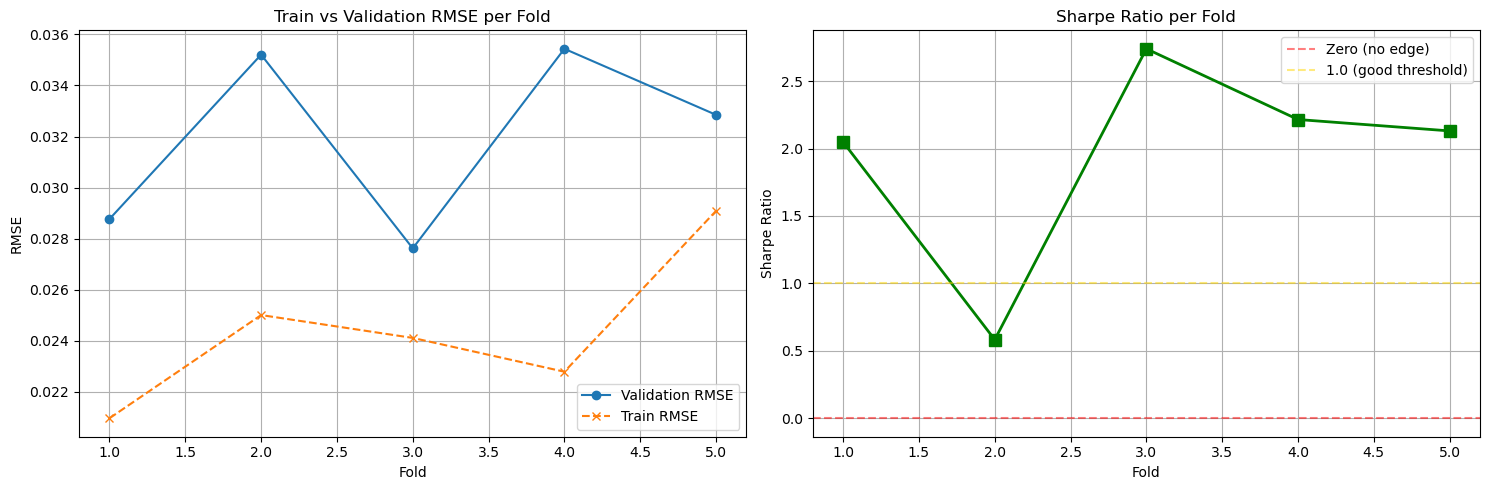

Average RMSE Gap (Validation - Train): 0.0076

--- Overall Metrics ---
Return volatility: 0.0323
Average up/down accuracy across all folds: 55.53%
Average Sharpe ratio across all folds: 1.943
Average validation RMSE across all folds: 0.0320
Validation RMSE < Validation Std Dev: 4/5 folds
([0.028765852314161552, 0.03520795635805035, 0.027617089462670285, 0.035437674275279926, 0.032849734994942086], <lightgbm.basic.Booster object at 0x133db6810>)
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's rmse: 0.0287561
Fold 1 - Train RMSE: 0.0210 | Validation RMSE: 0.0288
           Validation Std Dev: 0.0289 | Up/Down Accuracy: 56.21% | Sharpe: 2.048
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0352081
Fold 2 - Train RMSE: 0.0250 | Validation RMSE: 0.0352
           Validation Std Dev: 0.0351 | Up/Down Accuracy: 53.05% | Sharpe: 0.583
Training until validation sco

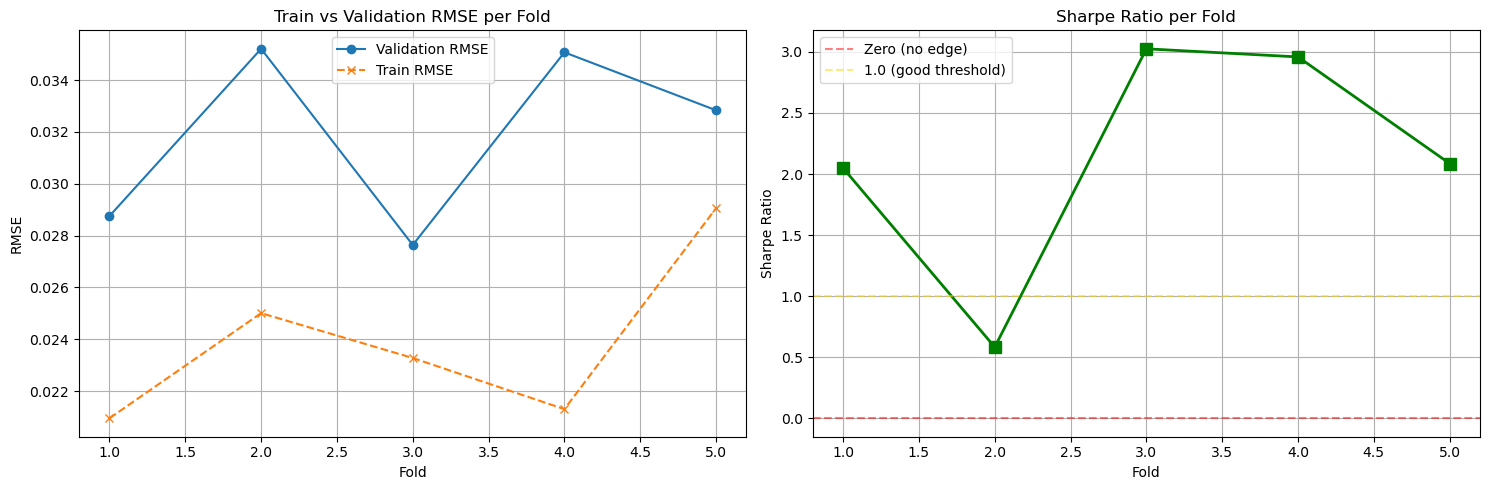

Average RMSE Gap (Validation - Train): 0.0080

--- Overall Metrics ---
Return volatility: 0.0323
Average up/down accuracy across all folds: 55.98%
Average Sharpe ratio across all folds: 2.140
Average validation RMSE across all folds: 0.0319
Validation RMSE < Validation Std Dev: 4/5 folds
([0.0287560884056537, 0.03520809704017111, 0.02763903956116705, 0.03507191132144744, 0.032836844015088296], <lightgbm.basic.Booster object at 0x1337fdbe0>)
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's rmse: 0.0288187
Fold 1 - Train RMSE: 0.0209 | Validation RMSE: 0.0288
           Validation Std Dev: 0.0289 | Up/Down Accuracy: 56.21% | Sharpe: 2.048
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0352191
Fold 2 - Train RMSE: 0.0250 | Validation RMSE: 0.0352
           Validation Std Dev: 0.0351 | Up/Down Accuracy: 53.05% | Sharpe: 0.583
Training until validation scores 

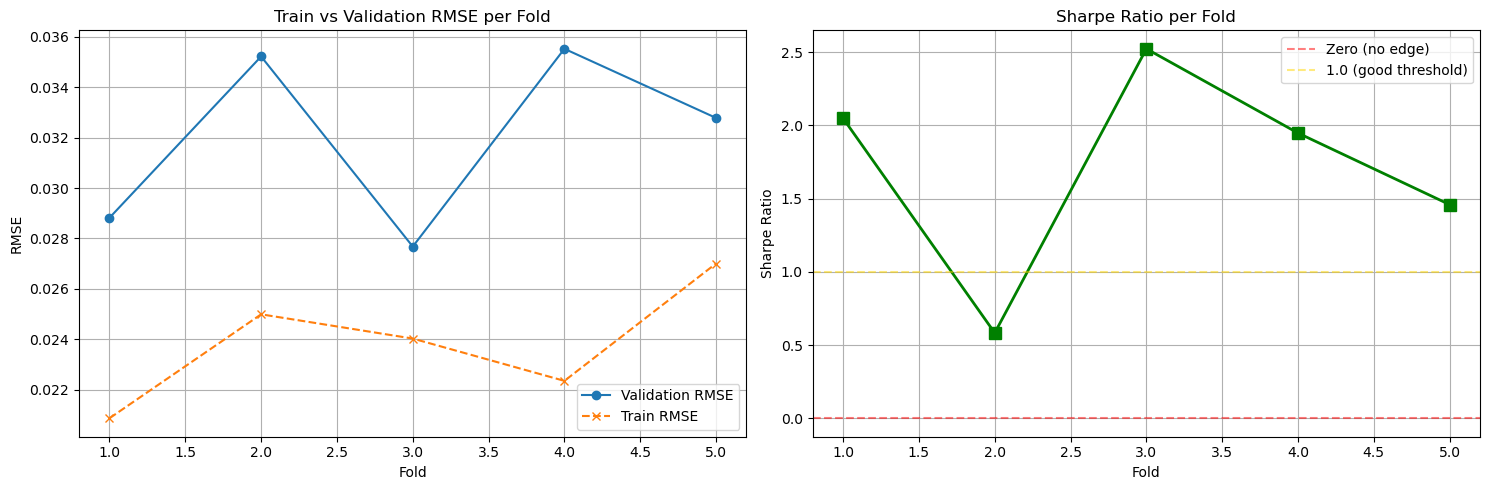

Average RMSE Gap (Validation - Train): 0.0082

--- Overall Metrics ---
Return volatility: 0.0323
Average up/down accuracy across all folds: 54.72%
Average Sharpe ratio across all folds: 1.712
Average validation RMSE across all folds: 0.0320
Validation RMSE < Validation Std Dev: 4/5 folds
([0.0288187166563933, 0.03521908023576843, 0.02767723695458891, 0.035523818731388254, 0.03278139515935084], <lightgbm.basic.Booster object at 0x133a26f30>)
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's rmse: 0.0288126
Fold 1 - Train RMSE: 0.0209 | Validation RMSE: 0.0288
           Validation Std Dev: 0.0289 | Up/Down Accuracy: 56.21% | Sharpe: 2.048
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0352583
Fold 2 - Train RMSE: 0.0250 | Validation RMSE: 0.0353
           Validation Std Dev: 0.0351 | Up/Down Accuracy: 53.05% | Sharpe: 0.583
Training until validation scores 

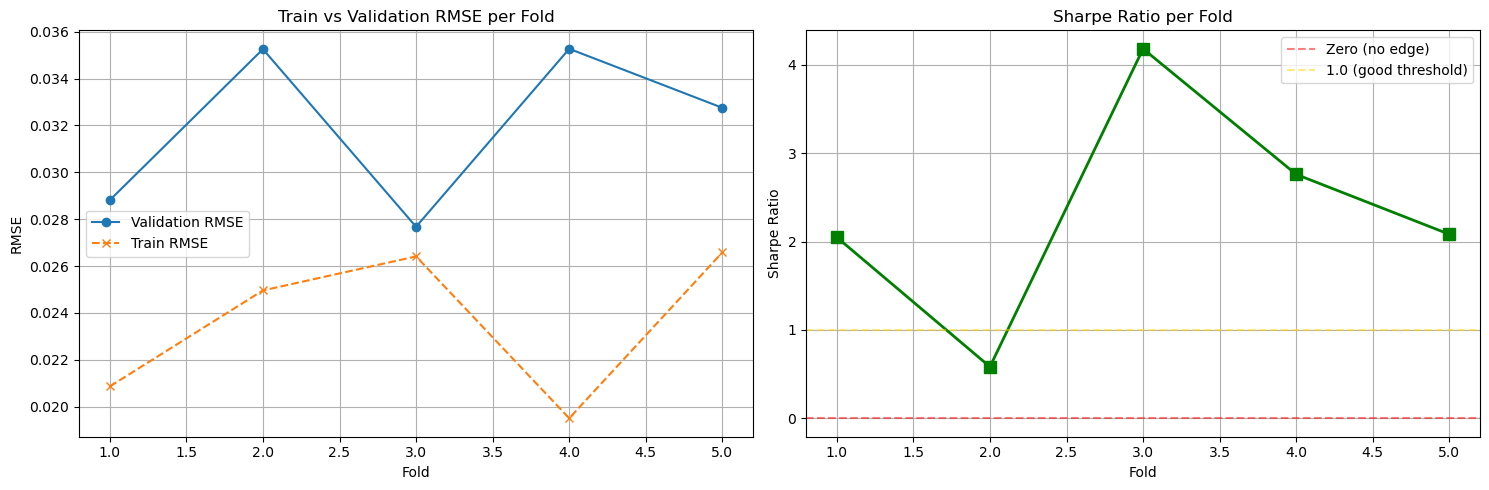

Average RMSE Gap (Validation - Train): 0.0083

--- Overall Metrics ---
Return volatility: 0.0323
Average up/down accuracy across all folds: 56.21%
Average Sharpe ratio across all folds: 2.331
Average validation RMSE across all folds: 0.0320
Validation RMSE < Validation Std Dev: 4/5 folds
([0.02881257892207723, 0.0352583100453897, 0.027676609885663287, 0.03527307643116521, 0.0327548398619472], <lightgbm.basic.Booster object at 0x133a3c140>)
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	valid_0's rmse: 0.0287678
Fold 1 - Train RMSE: 0.0207 | Validation RMSE: 0.0288
           Validation Std Dev: 0.0289 | Up/Down Accuracy: 56.21% | Sharpe: 2.048
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0351784
Fold 2 - Train RMSE: 0.0250 | Validation RMSE: 0.0352
           Validation Std Dev: 0.0351 | Up/Down Accuracy: 53.05% | Sharpe: 0.583
Training until validation scores d

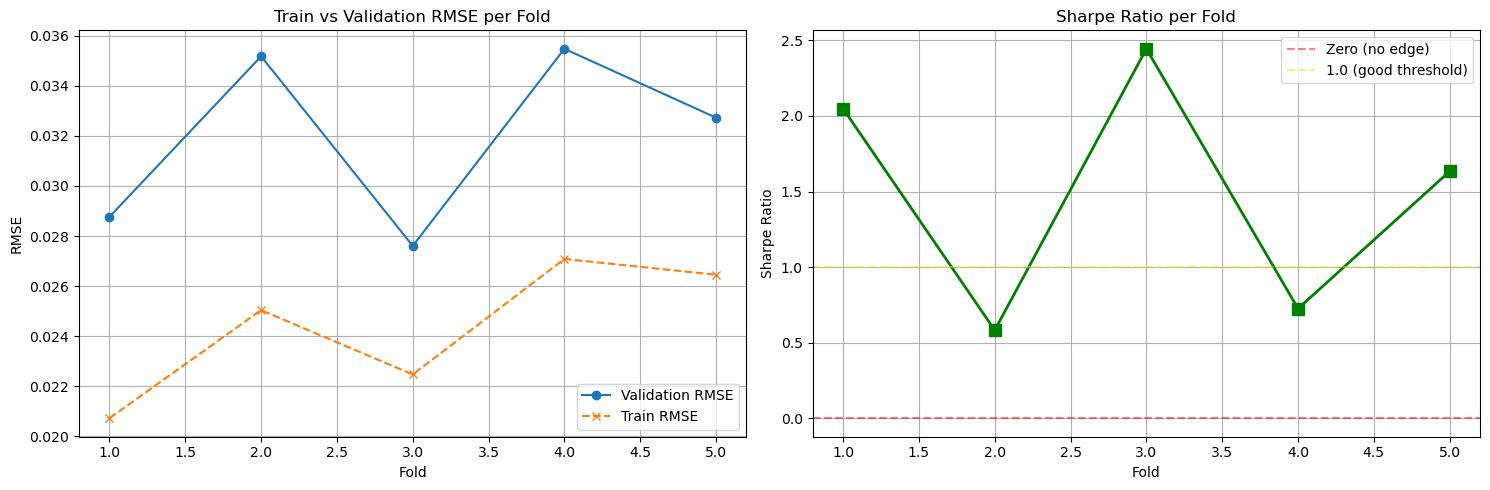

Average RMSE Gap (Validation - Train): 0.0076

--- Overall Metrics ---
Return volatility: 0.0323
Average up/down accuracy across all folds: 54.45%
Average Sharpe ratio across all folds: 1.487
Average validation RMSE across all folds: 0.0320
Validation RMSE < Validation Std Dev: 4/5 folds
([0.028767776553200532, 0.035178417269282336, 0.027606972878554143, 0.035478643268556834, 0.032727301270145503], <lightgbm.basic.Booster object at 0x1341438c0>)


In [20]:
## Analysing different feature combinations

X_01 = nvda_4[features_1]
X_02 = nvda_4[features_2]
X_03 = nvda_4[features_3]
X_04 = nvda_4[features_4]
X_05 = nvda_4[features_5]

print(train_lgb_model(X_01, y_6))
print(train_lgb_model(X_02, y_6))
print(train_lgb_model(X_03, y_6))
print(train_lgb_model(X_04, y_6))   
print(train_lgb_model(X_05, y_6))

Features_1 looks extremely promising! Lets hyperparameter tune to improve results even further.

[I 2025-08-30 15:49:53,067] A new study created in memory with name: LGB_Sharpe_Optimization


Starting hyperparameter optimization with 100 trials...
Optimizing for: Maximum Sharpe Ratio
CV folds: 5
--------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	valid_0's rmse: 0.0289945
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0351465
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	valid_0's rmse: 0.0284204
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's rmse: 0.0356384
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0330022
[I 2025-08-30 15:49:53,874] Trial 0 finished with value: 1.3387749074872641 and parameters: {'num_leaves': 118, 'learning_rate': 0.2536999076681772, 'feature_fraction': 0.839196365086843, 'bagging_fraction': 0.759195090518222, 'bagging_freq': 2, 'min_child_samples': 19, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469893, 'max_depth': 9, 'min_data_in

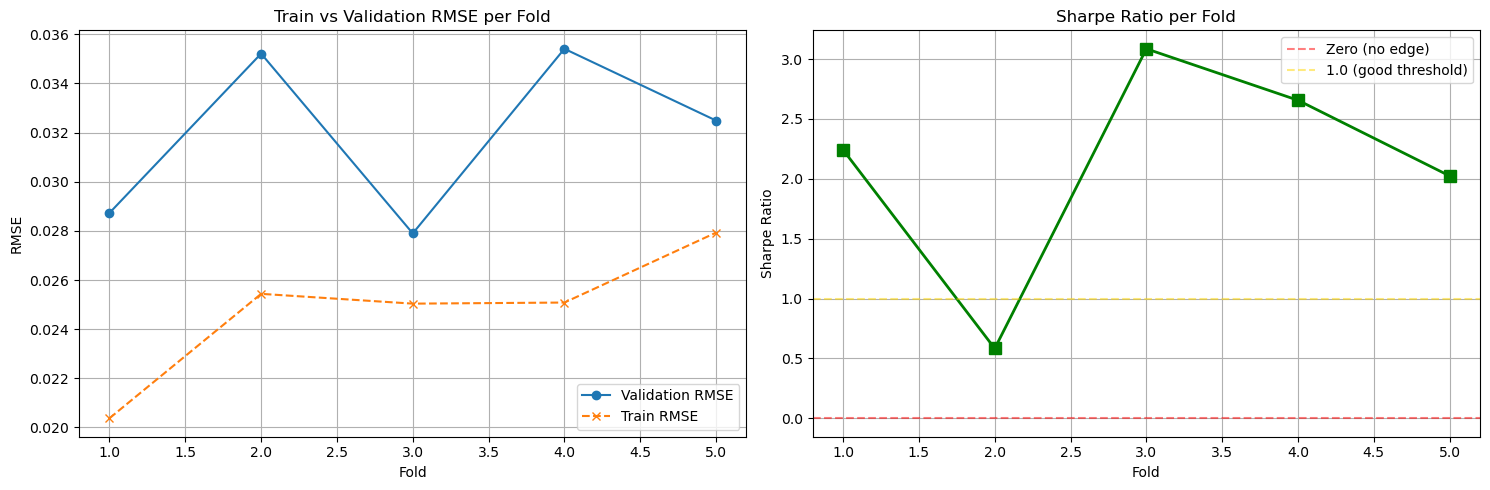

Average RMSE Gap (Validation - Train): 0.0072

--- Overall Metrics ---
Return volatility: 0.0323
Average up/down accuracy across all folds: 55.35%
Average Sharpe ratio across all folds: 2.118
Average validation RMSE across all folds: 0.0319
Validation RMSE < Validation Std Dev: 4/5 folds
Run the optimization with:
best_params, study = optimize_lgb_hyperparameters(X_01, y_6, n_trials=100, n_splits=5)
final_model, rmse_scores, final_params = train_with_best_params(X_01, y_6, best_params)


In [21]:
#!pip install optuna
import optuna


def lgb_sharpe_objective(trial, X, y, n_splits=5):
    """
    Optuna objective function that optimizes LightGBM hyperparameters for Sharpe ratio.
    """
    
    # Define hyperparameter search space
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        
        # Key hyperparameters to tune
        'num_leaves': trial.suggest_int('num_leaves', 10, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 50)
    }
    
    # Time series cross-validation
    tscv = TimeSeriesSplit(n_splits=n_splits)
    sharpe_ratios = []
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Create datasets
        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val)
        
        # Train model with early stopping
        model = lgb.train(
            params,
            train_data,
            num_boost_round=1000,
            valid_sets=[val_data],
            callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(0)]
        )
        
        # Make predictions
        val_preds = model.predict(X_val)
        
        # Calculate Sharpe ratio for this fold
        positions = np.sign(val_preds)
        strategy_returns = positions * y_val
        
        if strategy_returns.std() > 0:
            sharpe = np.sqrt(252) * (strategy_returns.mean() / strategy_returns.std())
        else:
            sharpe = 0
            
        sharpe_ratios.append(sharpe)
    
    # Return mean Sharpe ratio across all folds
    mean_sharpe = np.mean(sharpe_ratios)
    
    # Handle potential NaN/inf values
    if np.isnan(mean_sharpe) or np.isinf(mean_sharpe):
        return -999  # Very bad score
    
    return mean_sharpe

def optimize_lgb_hyperparameters(X, y, n_trials=100, n_splits=5):
    """
    Optimize LightGBM hyperparameters using Optuna with Sharpe ratio as objective.
    
    Args:
        X (pd.DataFrame): Features
        y (pd.Series): Target
        n_trials (int): Number of optimization trials
        n_splits (int): Number of CV folds
    
    Returns:
        dict: Best parameters and study object
    """
    
    print(f"Starting hyperparameter optimization with {n_trials} trials...")
    print(f"Optimizing for: Maximum Sharpe Ratio")
    print(f"CV folds: {n_splits}")
    print("-" * 50)
    
    # Create study
    study = optuna.create_study(
        direction='maximize',  # We want to maximize Sharpe ratio
        study_name='LGB_Sharpe_Optimization',
        sampler=optuna.samplers.TPESampler(seed=42)
    )
    
    # Optimize
    study.optimize(
        lambda trial: lgb_sharpe_objective(trial, X, y, n_splits),
        n_trials=n_trials,
        show_progress_bar=True
    )
    
    # Results
    print(f"\nOptimization complete!")
    print(f"Best Sharpe ratio: {study.best_value:.4f}")
    print(f"Best parameters:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")

    # Save best params
    import json
    with open('best_params.json', 'w') as f:
        json.dump(study.best_params, f, indent=2)
    print(f"\nBest parameters saved to 'best_params.json'")
    
    return study.best_params, study

def train_with_best_params(X, y, best_params, n_splits=5):
    """
    Train final model with best parameters and return detailed results.
    """
    
    # Add fixed parameters to best params
    final_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        **best_params
    }
    
    print(f"\nTraining final model with optimized parameters...")
    print("-" * 50)
    
    # Use your existing train_lgb_model function with optimized parameters
    rmse_scores, final_model = train_lgb_model(
        X, y, 
        n_splits=n_splits, 
        params=final_params,
        num_boost_round=1000,
        early_stopping_rounds=50
    )
    
    return final_model, rmse_scores, final_params

# Example usage:
X_01 = nvda_4[['Volatility5', 'Close_to_High10', 'Chaikin_Oscillator', 'Customer_Index_Return', 'DataCenter_Proxy_Return', 'Memory_Momentum_10d', 'ETH_Mining_Proxy']]
y_6 = nvda_4['Return']

if __name__ == "__main__":
    # Assuming you have X_01 and y_6 ready
    best_params, study = optimize_lgb_hyperparameters(X_01, y_6, n_trials=100, n_splits=5)
    final_model, rmse_scores, final_params = train_with_best_params(X_01, y_6, best_params, n_splits=5)
    
    print("Run the optimization with:")
    print("best_params, study = optimize_lgb_hyperparameters(X_01, y_6, n_trials=100, n_splits=5)")
    print("final_model, rmse_scores, final_params = train_with_best_params(X_01, y_6, best_params)")

This hyperparamter combination has produced a major increase in the volatility of SHARPE across folds. 
This represents high risk so I am going to redo the hyperparameter tuning to account for SHARPE voltility

In [ ]:
def robust_lgb_sharpe_objective(trial, X, y, n_splits=5, consistency_penalty=0.3):
    """
    Modified objective that penalizes Sharpe ratio inconsistency across folds.
    
    Args:
        consistency_penalty (float): How much to penalize Sharpe volatility (0-1)
                                   0 = no penalty, 1 = heavy penalty
    """
    
    # Same parameter space as before
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        
        'num_leaves': trial.suggest_int('num_leaves', 10, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 50)
    }
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    sharpe_ratios = []
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val)
        
        model = lgb.train(
            params,
            train_data,
            num_boost_round=1000,
            valid_sets=[val_data],
            callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(0)]
        )
        
        val_preds = model.predict(X_val)
        positions = np.sign(val_preds)
        strategy_returns = positions * y_val
        
        if strategy_returns.std() > 0:
            sharpe = np.sqrt(252) * (strategy_returns.mean() / strategy_returns.std())
        else:
            sharpe = 0
            
        sharpe_ratios.append(sharpe)
    
    # Calculate robust objective
    mean_sharpe = np.mean(sharpe_ratios)
    sharpe_std = np.std(sharpe_ratios)
    
    # Penalize high standard deviation
    robust_score = mean_sharpe - (consistency_penalty * sharpe_std)
    
    if np.isnan(robust_score) or np.isinf(robust_score):
        return -999
    
    return robust_score

def optimize_robust_lgb(X, y, n_trials=100, n_splits=5, consistency_penalty=0.3):
    """
    Optimize for both high Sharpe AND consistency across folds.
    
    Args:
        consistency_penalty (float): 
            0.0 = Only maximize mean Sharpe (original approach)
            0.3 = Moderate penalty for inconsistency (recommended)
            0.5 = Heavy penalty for inconsistency
    """
    
    print(f"Starting ROBUST Sharpe optimization...")
    print(f"Consistency penalty: {consistency_penalty} (higher = more consistent)")
    print(f"Objective: Mean Sharpe - {consistency_penalty} * Sharpe StdDev")
    print("-" * 60)
    
    study = optuna.create_study(
        direction='maximize',
        study_name=f'Robust_LGB_Sharpe_Penalty_{consistency_penalty}',
        sampler=optuna.samplers.TPESampler(seed=42)
    )
    
    study.optimize(
        lambda trial: robust_lgb_sharpe_objective(trial, X, y, n_splits, consistency_penalty),
        n_trials=n_trials,
        show_progress_bar=True
    )
    
    print(f"\nRobust optimization complete!")
    print(f"Best robust score: {study.best_value:.4f}")
    print(f"Best parameters:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")
    
    return study.best_params, study

# Quick function to compare approaches
def compare_optimization_strategies(X, y, n_trials=50):
    """
    Compare different consistency penalty levels.
    """
    
    strategies = [
        (0.0, "Pure Mean Sharpe (Original)"),
        (0.2, "Light Consistency Penalty"), 
        (0.3, "Moderate Consistency Penalty"),
        (0.4, "Heavy Consistency Penalty")
    ]
    
    results = {}
    
    for penalty, name in strategies:
        print(f"\n{'='*50}")
        print(f"Testing: {name}")
        print(f"{'='*50}")
        
        best_params, study = optimize_robust_lgb(
            X, y, 
            n_trials=n_trials, 
            consistency_penalty=penalty
        )
        
        results[name] = {
            'penalty': penalty,
            'best_score': study.best_value,
            'best_params': best_params
        }
    
    return results

def analyze_top_candidates(study, X, y, top_n=3, n_splits=5):
    """
    Analyze the top N parameter combinations from optimization study.
    
    Returns detailed analysis of each candidate including:
    - Individual fold performance
    - Consistency metrics  
    - Risk-adjusted performance
    """
    
    print(f"\n{'='*80}")
    print(f"ANALYZING TOP {top_n} HYPERPARAMETER CANDIDATES")
    print(f"{'='*80}")
    
    # Get top N trials
    top_trials = study.trials_dataframe().nlargest(top_n, 'value')
    
    candidates = {}
    
    for rank, (idx, row) in enumerate(top_trials.iterrows(), 1):
        print(f"\n{'-'*60}")
        print(f"CANDIDATE #{rank} (Trial {row['number']}) - Score: {row['value']:.4f}")
        print(f"{'-'*60}")
        
        # Extract parameters (remove 'params_' prefix)
        params = {}
        for col in row.index:
            if col.startswith('params_'):
                param_name = col.replace('params_', '')
                params[param_name] = row[col]
        
        # Add fixed parameters
        final_params = {
            'objective': 'regression',
            'metric': 'rmse',
            'verbosity': -1,
            'boosting_type': 'gbdt',
            'random_state': 42,
            **params
        }
        
        print("Parameters:")
        for key, value in params.items():
            print(f"  {key}: {value}")
        
        # Train and evaluate this candidate
        print(f"\nEvaluating Candidate #{rank}...")
        rmse_scores, model = train_lgb_model(
            X, y, 
            n_splits=n_splits, 
            params=final_params,
            num_boost_round=1000,
            early_stopping_rounds=50
        )
        
        # Calculate additional consistency metrics
        # Re-calculate Sharpe ratios for analysis
        tscv = TimeSeriesSplit(n_splits=n_splits)
        sharpe_ratios = []
        
        for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            train_data = lgb.Dataset(X_train, label=y_train)
            val_data = lgb.Dataset(X_val, label=y_val)
            
            temp_model = lgb.train(
                final_params,
                train_data,
                num_boost_round=1000,
                valid_sets=[val_data],
                callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(0)]
            )
            
            val_preds = temp_model.predict(X_val)
            positions = np.sign(val_preds)
            strategy_returns = positions * y_val
            
            if strategy_returns.std() > 0:
                sharpe = np.sqrt(252) * (strategy_returns.mean() / strategy_returns.std())
            else:
                sharpe = 0
                
            sharpe_ratios.append(sharpe)
        
        # Calculate consistency metrics
        mean_sharpe = np.mean(sharpe_ratios)
        sharpe_std = np.std(sharpe_ratios)
        sharpe_min = np.min(sharpe_ratios)
        sharpe_max = np.max(sharpe_ratios)
        
        print(f"\n*** CONSISTENCY ANALYSIS FOR CANDIDATE #{rank} ***")
        print(f"Sharpe Ratios by Fold: {[f'{s:.3f}' for s in sharpe_ratios]}")
        print(f"Mean Sharpe: {mean_sharpe:.4f}")
        print(f"Sharpe Std Dev: {sharpe_std:.4f}")
        print(f"Sharpe Range: {sharpe_min:.3f} to {sharpe_max:.3f}")
        print(f"Consistency Score: {mean_sharpe - 0.4 * sharpe_std:.4f} (Mean - 0.4*StdDev)")
        
        # Store results
        candidates[f'candidate_{rank}'] = {
            'rank': rank,
            'trial_number': row['number'],
            'optimization_score': row['value'],
            'parameters': params,
            'final_params': final_params,
            'model': model,
            'rmse_scores': rmse_scores,
            'sharpe_ratios': sharpe_ratios,
            'mean_sharpe': mean_sharpe,
            'sharpe_std': sharpe_std,
            'sharpe_range': (sharpe_min, sharpe_max),
            'consistency_score': mean_sharpe - 0.4 * sharpe_std
        }
    
    # Final comparison summary
    print(f"\n{'='*80}")
    print("FINAL COMPARISON SUMMARY")
    print(f"{'='*80}")
    print(f"{'Rank':<6} {'OptScore':<10} {'Mean Sharpe':<12} {'Sharpe StdDev':<12} {'Consistency':<12} {'Sharpe Range':<15}")
    print("-" * 80)
    
    for name, data in candidates.items():
        rank = data['rank']
        opt_score = data['optimization_score']
        mean_sharpe = data['mean_sharpe'] 
        sharpe_std = data['sharpe_std']
        consistency = data['consistency_score']
        sharpe_range = f"{data['sharpe_range'][0]:.2f}-{data['sharpe_range'][1]:.2f}"
        
        print(f"{rank:<6} {opt_score:<10.4f} {mean_sharpe:<12.4f} {sharpe_std:<12.4f} {consistency:<12.4f} {sharpe_range:<15}")
    
    print(f"\n*** RECOMMENDATION ***")
    
    # Find most consistent candidate
    most_consistent = min(candidates.items(), key=lambda x: x[1]['sharpe_std'])
    highest_mean = max(candidates.items(), key=lambda x: x[1]['mean_sharpe'])
    best_consistency_score = max(candidates.items(), key=lambda x: x[1]['consistency_score'])
    
    print(f"Most Consistent: Candidate #{most_consistent[1]['rank']} (StdDev: {most_consistent[1]['sharpe_std']:.4f})")
    print(f"Highest Mean Sharpe: Candidate #{highest_mean[1]['rank']} (Sharpe: {highest_mean[1]['mean_sharpe']:.4f})")
    print(f"Best Consistency Score: Candidate #{best_consistency_score[1]['rank']} (Score: {best_consistency_score[1]['consistency_score']:.4f})")
    
    print(f"\nFor daily trading, I recommend: Candidate #{most_consistent[1]['rank']} (most consistent)")
    
    return candidates

def train_with_robust_params(X, y, best_params, n_splits=5):
    """
    Train final model with robust parameters and return detailed results.
    """
    
    # Add fixed parameters to best params
    final_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        **best_params
    }
    
    print(f"\nTraining final model with ROBUST optimized parameters...")
    print("-" * 60)
    
    # Use your existing train_lgb_model function with optimized parameters
    rmse_scores, final_model = train_lgb_model(
        X, y, 
        n_splits=n_splits, 
        params=final_params,
        num_boost_round=1000,
        early_stopping_rounds=50
    )
    
    return final_model, rmse_scores, final_params

# EXECUTION CODE - ADD THIS TO RUN THE ACTUAL OPTIMIZATION
if __name__ == "__main__":
    print("="*70)
    print("ROBUST SHARPE HYPERPARAMETER OPTIMIZATION")
    print("="*70)
    
    # Step 1: Run robust optimization (prioritizing consistency)
    print("\nStep 1: Running robust hyperparameter optimization...")
    best_params, study = optimize_robust_lgb(
        X_01, y_6, 
        n_trials=100,  # Adjust this number based on time available
        n_splits=5, 
        consistency_penalty=0.4  # Higher penalty = more consistent
    )
    
    # Step 2: Analyze top 3 candidates in detail
    print("\nStep 2: Analyzing top candidates...")
    candidates = analyze_top_candidates(study, X_01, y_6, top_n=3, n_splits=5)
    
    print("\n" + "="*70)
    print("OPTIMIZATION COMPLETE!")
    print("="*70)
    
    print("\nAll candidate analyses saved in 'candidates' dictionary")
    print("Access individual candidates: candidates['candidate_1'], candidates['candidate_2'], etc.")
    print("\nTo use the most consistent model:")
    print("most_consistent = min(candidates.items(), key=lambda x: x[1]['sharpe_std'])")
    print("chosen_model = most_consistent[1]['model']")
    print("chosen_params = most_consistent[1]['final_params']")


[I 2025-08-30 15:51:09,383] A new study created in memory with name: Robust_LGB_Sharpe_Penalty_0.4


ROBUST SHARPE HYPERPARAMETER OPTIMIZATION

Step 1: Running robust hyperparameter optimization...
Starting ROBUST Sharpe optimization...
Consistency penalty: 0.4 (higher = more consistent)
Objective: Mean Sharpe - 0.4 * Sharpe StdDev
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	valid_0's rmse: 0.0289945
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0351465
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	valid_0's rmse: 0.0284204
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's rmse: 0.0356384
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0330022
[I 2025-08-30 15:51:10,126] Trial 0 finished with value: 1.073102151718838 and parameters: {'num_leaves': 118, 'learning_rate': 0.2536999076681772, 'feature_fraction': 0.839196365086843, 'bagging_fraction': 0.759195090518222, 'bagging_freq': 2, 'min_child_samples': 19, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469893, 'max_depth': 9, 'min_data_in_

Hyperparameter tuned Model 1 is showing strong potential, however the drop in Sharpe ratio to ~0.5 in fold 2 is concerning.

 This occurs during the COVID period, and I believe the issue stems from insufficient regime detection indicators: the model performs exceptionally well during fundamental-driven regime periods but struggles when markets become liquidity-dominated (COVID - fold 2).
 
  This makes sense given our 7 current features are entirely short-term momentum/technical based. To address this limitation, I plan to add regime detection indicators by running forward selection with the 10 most impactful regime indicators.

In [ ]:
# Add Return_in_High_VIX to nvda_4
nvda_4['Return_in_High_VIX'] = nvda_4['Return'] * nvda_4['High_VIX_Regime']